# Import Libraries

Import necessary libraries to start initial importing of data and plotting libraries.  The functions library is a python helper file that I wrote to import all the class functions.  The Stats function does a comparison of datasets distributions and finds if normal or not and then run the appropriate test for comparison.  The dataProcessing class pre-processes the data and add features using feature engineering.  Additionally it will remove outliers and put the label at the end of the dataframe.  Finally the Models class iterates through models and parameters and returns a dataframe with the models results. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import functions as fn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cufflinks as cf
cf.set_config_file(offline=True)

from pandas_profiling import ProfileReport

## Pandas Settings

Setup the initial setting used for pandas in the notebook.

In [2]:
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## Set Initial Parameters

Set colors and start date that will be used in the entire notebook.

In [3]:
colorIreland = '#006400'
colorGermany = '#DAA520'
colorUSA  = '#3E6FB0'

startDate = '1992-01-01'
endDate = '2020-12-31'

## Functions 

Some initial functions that will be used in the formating of dates in the notebook. 

In [4]:
def formatDates(data, position):
    '''This method converts the day of the month to the first date in the dataframe.
    When resampling dates the dates can be all over the place.  This is important
    when merging dataframes.

    Args:
    data (data frame): The dataset with datetime columns.
    position (int): This is the number of column the datetime column is in the dataframe.

    Returns:
    dates (string array): datetime string array that will be converted into datetime.

    Notes: 
    '''
    dates = []
    for index, row in data.iterrows():
        # Iterate through each row and append the 01 for first of the month date.
        dates.append(str(row[position])[:8] + '01')
    return dates

def resampleMonthly(data, dateColumn, dateLocation, method):
    '''This method resamples annual dataframe into monthly.  This is upsampling
    and the method used to upsample will be to interpolate and user states method
    to interpolate.  This does create a linear number in your dataset but could 
    have issues with leakage.

    Args:
    data (data frame): The dataset containing dataframe to be resampled.
    dateColumn (string): Name of the date column to be resampled.
    dateLocation (int): This is the number of column the datetime column is in the dataframe.
    on (string): This is the name of column the datetime column is to be resampled.
    method (string): 

    Returns:
    data (data frame): The dataframe resampled with new dates.

    Notes: 
    https://www.geeksforgeeks.org/how-to-resample-time-series-data-in-python/
    '''
    df = data.resample('M', on=dateColumn).mean().interpolate(method=method)
    df.reset_index(inplace=True)
    df[dateColumn] = formatDates(df, dateLocation)
    df[dateColumn] = pd.to_datetime(df[dateColumn])
    df.sort_values(dateColumn, inplace=True)
    df.set_index(dateColumn,inplace=True)
    return df

# All EU Dataset

Import the dataset from the EU that contains all the countries and production of livestock.  Here the dataset needs to be filtered for only for tonnes and further filtering of the time, location, meat and value.  Columns renames and then date formated and filter for dates from start date.  Country column will only get the name of the country needed.  Additionally remove any colons from dataset and ensure that value column is a float.  Once all done reset index and print. 

https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/apro_mt_pwgtm.tsv.gz

In [5]:
# https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/apro_mt_pwgtm.tsv.gz
EUdata = pd.read_csv('data/apro_mt_pwgtm_1_Data.csv')
EUdata = EUdata[EUdata['UNIT'] == 'Thousand tonnes']
EUdata = EUdata[['TIME', 'GEO', 'MEAT', 'Value']]
EUdata.columns = ['Date', 'Country', 'Meat', 'Value']

EUdata.Date = pd.to_datetime(EUdata.Date, format='%YM%m')
EUdata = EUdata[(EUdata.Date >= startDate) & (EUdata.Date <= endDate)]

EUdata['Country'] = EUdata['Country'].str.slice(0,7)
EUdata = EUdata.replace([':'], 0, regex=True)
EUdata['Value'] = EUdata['Value'].astype(float)

EUdata.reset_index(inplace=True, drop=True)
EUdata

Date  Country          Meat    Value
0    1992-01-01  Germany   Bovine meat 159.1700
1    1992-01-01  Germany       Pigmeat 323.2400
2    1992-01-01  Germany     Sheepmeat   2.9100
3    1992-01-01  Germany  Poultry meat   0.0000
4    1992-01-01  Ireland   Bovine meat  35.0000
...         ...      ...           ...      ...
2779 2020-12-01  Germany  Poultry meat 140.0000
2780 2020-12-01  Ireland   Bovine meat  48.3900
2781 2020-12-01  Ireland       Pigmeat  25.6500
2782 2020-12-01  Ireland     Sheepmeat   5.5000
2783 2020-12-01  Ireland  Poultry meat  21.1700

[2784 rows x 4 columns]

In [6]:
# Verify dtypes
EUdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784 entries, 0 to 2783
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2784 non-null   datetime64[ns]
 1   Country  2784 non-null   object        
 2   Meat     2784 non-null   object        
 3   Value    2784 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 87.1+ KB


# Ireland Slaughter Data

Now filtering from the EU dataset Ireland data only.  Poultry will not be used as Ireland has many missing values for years of counts.  Dataframe is then pivoted to show years as index and meats as columns and values in the dataframe.  Sort the dataframe on dates and rename columns to be consistent.

In [7]:
irelandData = EUdata[EUdata['Country'] == 'Ireland'].reset_index(drop=True)
irelandData = irelandData[irelandData.Meat != 'Poultry meat']
irelandData = irelandData.pivot_table(index='Date', columns='Meat', values='Value')
irelandData.reset_index(inplace=True)
irelandData.sort_values('Date', inplace=True, ascending= True)
irelandData.set_index('Date',inplace=True)

irelandData.columns = ['Ireland Bovine Meat', 'Ireland Pig Meat', 'Ireland Lamb Meat']
irelandData

Ireland Bovine Meat  Ireland Pig Meat  Ireland Lamb Meat
Date                                                                
1992-01-01              35.0000           17.9000             6.5000
1992-02-01              31.9000           15.0000             5.3000
1992-03-01              46.7000           16.5000             4.7000
1992-04-01              40.0000           16.0000             5.9000
1992-05-01              33.8000           15.9000             7.9000
...                         ...               ...                ...
2020-08-01              52.3200           24.9400             5.1100
2020-09-01              55.6300           27.5900             6.3100
2020-10-01              57.5800           27.5100             6.1300
2020-11-01              55.8800           29.3300             5.3700
2020-12-01              48.3900           25.6500             5.5000

[348 rows x 3 columns]

## Ireland Data NaN Count

In [8]:
# Verify no NaN count
irelandData.isna().sum()

Ireland Bovine Meat    0
Ireland Pig Meat       0
Ireland Lamb Meat      0
dtype: int64

## Ireland Dtypes

In [9]:
# Verify dtypes
irelandData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1992-01-01 to 2020-12-01
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ireland Bovine Meat  348 non-null    float64
 1   Ireland Pig Meat     348 non-null    float64
 2   Ireland Lamb Meat    348 non-null    float64
dtypes: float64(3)
memory usage: 10.9 KB


## Ireland Data Box Plot

In [10]:
fig = px.box(irelandData, points='all')
fig.update_layout(title_text='Livestock Slaughterings Ireland', 
                  title_x=0.5, legend_title='Livestock')
fig.update_traces(marker_color=colorIreland)
fig.show();

## Ireland Slaughter Plot

In [11]:
fig = px.line(irelandData, labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Ireland', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Ireland Slaughter Growth Plot

In [12]:
(irelandData.iloc[-1] - irelandData.iloc[0]) / irelandData.iloc[0]

Ireland Bovine Meat    0.3826
Ireland Pig Meat       0.4330
Ireland Lamb Meat     -0.1538
dtype: float64

In [13]:
fig = px.line(((1 + irelandData.pct_change()).cumprod() - 1).dropna(),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland Since 1992', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Ireland Monthly Variance Plot

In [14]:
fig = px.bar(irelandData[200:-1].pct_change()['Ireland Bovine Meat'], 
             labels={'value': 'Percentage Growth', 'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland Since 2010', 
                  title_x=0.5, legend_title='Livestock')
fig.update_traces(marker_color=colorIreland)
fig.show()

In [15]:
fig = px.line(irelandData[['Ireland Bovine Meat', 'Ireland Pig Meat', 
                           'Ireland Lamb Meat']].pct_change(), 
              labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Ireland Month to Month Variance Since 1992', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

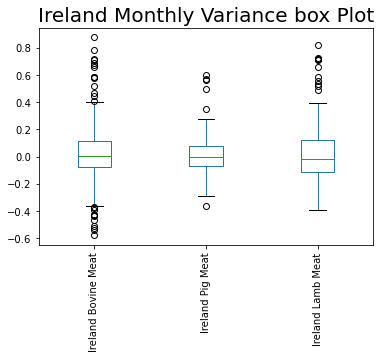

In [16]:
irelandData[['Ireland Bovine Meat', 'Ireland Pig Meat', 
                           'Ireland Lamb Meat']].pct_change().plot(kind='box', rot=90)
plt.title("Ireland Monthly Variance box Plot", fontsize=20);

# Germany Slaughter Data

Now filtering from the EU dataset German data only. Dataframe is then pivoted to show years as index and meats as columns and values in the dataframe.  Sort the dataframe on dates and rename columns to be consistent.

In [17]:
germanData = EUdata[EUdata['Country'] == 'Germany'].reset_index(drop=True)
germanData = germanData[germanData.Meat != 'Poultry meat']
germanData = germanData.pivot_table(index='Date', columns='Meat', values='Value')
germanData.sort_values('Date', inplace=True, ascending= True)
germanData.reset_index(inplace=True)
germanData.set_index('Date',inplace=True)
germanData.columns = ['Germany Bovine Meat', 'Germany Pig Meat', 'Germany Lamb Meat']
germanData

Germany Bovine Meat  Germany Pig Meat  Germany Lamb Meat
Date                                                                
1992-01-01             159.1700          323.2400             2.9100
1992-02-01             140.1100          285.4000             2.5200
1992-03-01             164.5400          316.9800             3.1600
1992-04-01             155.6100          297.4600             3.6500
1992-05-01             144.8200          300.1500             2.7000
...                         ...               ...                ...
2020-08-01              85.0000          422.0000             2.0000
2020-09-01              94.0000          437.0000             2.0000
2020-10-01             103.0000          432.0000             2.0000
2020-11-01              98.0000          439.0000             2.0000
2020-12-01              96.0000          417.0000             2.0000

[348 rows x 3 columns]

## Germany NaN Count

In [18]:
germanData.isna().sum()

Germany Bovine Meat    0
Germany Pig Meat       0
Germany Lamb Meat      0
dtype: int64

## German Dtypes

In [19]:
germanData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1992-01-01 to 2020-12-01
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Germany Bovine Meat  348 non-null    float64
 1   Germany Pig Meat     348 non-null    float64
 2   Germany Lamb Meat    348 non-null    float64
dtypes: float64(3)
memory usage: 10.9 KB


## Germany Data Box Plot

In [20]:
fig = px.box(germanData, points='all')
fig.update_layout(title_text='Livestock Slaughterings Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.update_traces(marker_color=colorGermany)
fig.show()

## Germany Slaughter Plot

In [21]:
fig = px.line(germanData, labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Germany Slaughter Growth Plot

In [22]:
(germanData.iloc[-2] - germanData.iloc[0]) / germanData.iloc[0]

Germany Bovine Meat   -0.3843
Germany Pig Meat       0.3581
Germany Lamb Meat     -0.3127
dtype: float64

In [23]:
fig = px.line(((1 + germanData.pct_change()).cumprod() - 1),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Germany Monthly Variance Plot

In [24]:
# Month to month Bar plot
fig = px.bar(germanData[200:].pct_change()['Germany Bovine Meat'], 
             labels={'value': 'Percentage Growth', 'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Germany Since 2010', 
                  title_x=0.5, legend_title='Livestock')
fig.update_traces(marker_color=colorGermany)
fig.show()

In [25]:
# Month to month line plot
fig = px.line(germanData[['Germany Bovine Meat', 'Germany Pig Meat', 
                           'Germany Lamb Meat']].pct_change(), 
              labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Germany Month to Month Variance Since 1992', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

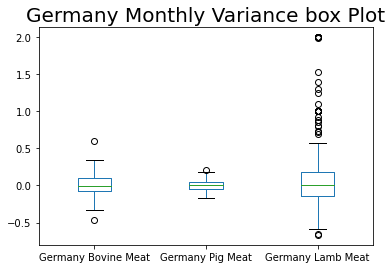

In [26]:
germanData[['Germany Bovine Meat', 'Germany Pig Meat', 
                           'Germany Lamb Meat']].pct_change().plot(kind='box')
plt.title("Germany Monthly Variance box Plot", fontsize=20);

# USA Slaughter Data

Dataset was downloaded from the USDA website and selecting the right tab for weights of slaughterings. Importing the dates and right sheet in spreadsheet was a bit of challenge.  Dropping the last rows that explain and dropping non needed columns.  Could have done keep columns instead but that is the way I went.  Convert date column to datetime and then filter only dates needed and finally sorting and casting dtype. 

https://www.ers.usda.gov/data-products/livestock-and-meat-domestic-data/livestock-and-meat-domestic-data/#All%20Meat%20Statistics

In [27]:
#https://www.ers.usda.gov/data-products/livestock-and-meat-domestic-data/livestock-and-meat-domestic-data/#All%20Meat%20Statistics
usaData = pd.read_excel('data/MeatStatsFullUSA.xlsx', sheet_name='RedMeatPoultry_Prod-Full',
                   skiprows=1, parse_dates=['Type 1/'])
usaData.drop(usaData.tail(9).index, inplace=True)
usaData.drop(usaData.columns[[1,2,3,4,5,6,8,11,12,13,14,15, 16,17]], axis=1, inplace=True)
usaData.columns=['Date','USA Bovine Meat', 'USA Pig Meat', 'USA Lamb Meat']
usaData.drop(usaData.head(3).index, inplace=True)
usaData.Date = pd.to_datetime(usaData.Date, format='%b-%Y')
usaData = usaData[(usaData.Date >= startDate) & (usaData.Date <= endDate)].reset_index(drop=True)
usaData.sort_values('Date', inplace=True, ascending=True)
usaData.set_index('Date', inplace=True)
usaData = usaData.astype(float)
usaData

USA Bovine Meat  USA Pig Meat  USA Lamb Meat
Date                                                    
1992-01-01        1998.0000     1491.0000        30.0000
1992-02-01        1671.0000     1300.0000        27.0000
1992-03-01        1812.0000     1436.0000        32.0000
1992-04-01        1751.0000     1385.0000        32.0000
1992-05-01        1867.0000     1261.0000        24.0000
...                     ...           ...            ...
2020-08-01        2298.0000     2326.8000         9.5000
2020-09-01        2315.3000     2322.5000         9.4000
2020-10-01        2431.9000     2585.8000         9.2000
2020-11-01        2232.3000     2395.1000         9.3000
2020-12-01        2291.8000     2499.3000        10.7000

[348 rows x 3 columns]

## USA Data NaN Count

In [28]:
usaData.isna().sum()

USA Bovine Meat    0
USA Pig Meat       0
USA Lamb Meat      0
dtype: int64

## USA Dtypes

In [29]:
usaData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1992-01-01 to 2020-12-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   USA Bovine Meat  348 non-null    float64
 1   USA Pig Meat     348 non-null    float64
 2   USA Lamb Meat    348 non-null    float64
dtypes: float64(3)
memory usage: 10.9 KB


## USA Data Box Plot

In [30]:
#https://plotly.com/python/box-plots/
fig = px.box(usaData)
fig.update_layout(title_text='Livestock Slaughterings USA', 
                  title_x=0.5, legend_title='Livestock')
fig.update_traces(marker_color=colorUSA)
fig.show()

## Convert USA Data to Tonne

This extra step had to be done and glad I did as I verified how the data is collected and found that I was on the wrong sheet.  I was looking at average weight per slaughter.  What tipped me off as well is that the number did not change in 30 years.  US data is shown in million pounds and this has to be converted into kilos and then into metric kilos. The numbers were further verified on the FAO website and for 2019 production for USA bovine meat was 12.348 and summing converted data returned 12.165.  There is a small difference but is acceptable. 

https://www.convertunits.com/from/lbs/to/metric+ton

In [31]:
#First convert pounds into million then convert into kilos and finally into metric tonne
#https://www.convertunits.com/from/lbs/to/metric+ton
usaData = usaData * (1/2.2046226218488)
usaData

USA Bovine Meat  USA Pig Meat  USA Lamb Meat
Date                                                    
1992-01-01         906.2776      676.3062        13.6078
1992-02-01         757.9529      589.6701        12.2470
1992-03-01         821.9094      651.3586        14.5150
1992-04-01         794.2402      628.2254        14.5150
1992-05-01         846.8570      571.9800        10.8862
...                     ...           ...            ...
2020-08-01        1042.3553     1055.4187         4.3091
2020-09-01        1050.2024     1053.4683         4.2638
2020-10-01        1103.0913     1172.8992         4.1730
2020-11-01        1012.5542     1086.3991         4.2184
2020-12-01        1039.5430     1133.6634         4.8534

[348 rows x 3 columns]

In [32]:
usaData[(usaData.index >= '2019-01-01')&(usaData.index <= '2019-12-01')].sum()

USA Bovine Meat   12165.9824
USA Pig Meat      12476.8292
USA Lamb Meat        60.7360
dtype: float64

## USA Slaughter Plot

In [33]:
fig = px.line(usaData, labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings USA', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## USA Slaughter Growth Plot

In [34]:
(usaData.iloc[-1] - usaData.iloc[0]) / usaData.iloc[0]

USA Bovine Meat    0.1470
USA Pig Meat       0.6763
USA Lamb Meat     -0.6433
dtype: float64

In [35]:
fig = px.line(((1 + usaData.pct_change()).cumprod() - 1),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth USA', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## USA Monthly Variance Plot

In [36]:
fig = px.bar(usaData[200:].pct_change()['USA Bovine Meat'], 
             labels={'value': 'Percentage Growth', 'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland', 
                  title_x=0.5, legend_title='Livestock')
fig.update_traces(marker_color=colorUSA)
fig.show()

In [37]:
# Month to month line plot
fig = px.line(usaData[['USA Bovine Meat', 'USA Pig Meat', 
                           'USA Lamb Meat']].pct_change(), 
              labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings USA Month to Month Variance Since 1992', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

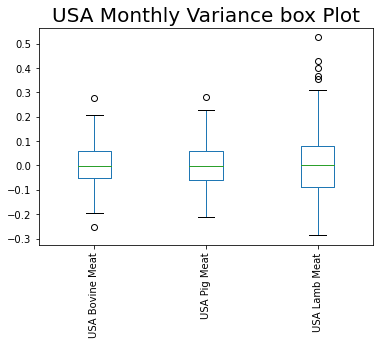

In [38]:
usaData[['USA Bovine Meat', 'USA Pig Meat', 
                           'USA Lamb Meat']].pct_change().plot(kind='box', rot=90)

plt.title("USA Monthly Variance box Plot", fontsize=20);

# Economic Data Import

Economic data will be imported to see if the question of wealth and substitution effect can predict bovine meat production.  Data was imported from various different sources and normalized / converted where need for comparison analysis.  

## Population Data

Population data was downloaded from the Federal Reserve Economic Data.

### Ireland Population Data

In [39]:
# https://fred.stlouisfed.org/series/POPTOTIEA647NWDB
irelandPop = pd.read_csv('data/POPTOTIEA647NWDB.csv', 
                         parse_dates=['DATE'])
irelandPop.columns = ['Date','Ireland Population']
irelandPop.Date = pd.to_datetime(irelandPop.Date)
irelandPop.sort_values('Date', inplace=True, ascending= True)
irelandPop = irelandPop[irelandPop.Date >= startDate]

irelandPop = resampleMonthly(irelandPop, 'Date', 0, 'linear')

### Germany Population Data

In [40]:
# https://fred.stlouisfed.org/series/POPTOTDEA647NWDB
germanyPop = pd.read_csv('data/POPTOTDEA647NWDB.csv',
                    parse_dates=['DATE'])
germanyPop.columns = ['Date','German Population']
germanyPop.Date = pd.to_datetime(germanyPop.Date)
germanyPop.sort_values('Date', inplace=True, ascending= True)
germanyPop = germanyPop[germanyPop.Date >= startDate]

germanyPop = resampleMonthly(germanyPop, 'Date', 0, 'linear')
germanyPop

German Population
Date                         
1992-01-01      80624598.0000
1992-02-01      80668911.7500
1992-03-01      80713225.5000
1992-04-01      80757539.2500
1992-05-01      80801853.0000
...                       ...
2019-09-01      83191337.3333
2019-10-01      83203634.2500
2019-11-01      83215931.1667
2019-12-01      83228228.0833
2020-01-01      83240525.0000

[337 rows x 1 columns]

### USA Population Data

In [41]:
# https://fred.stlouisfed.org/series/POPTOTUSA647NWDB
usaPop = pd.read_csv('data/POPTOTUSA647NWDB.csv',
                    parse_dates=['DATE'])
usaPop.columns = ['Date','USA Population']
usaPop.Date = pd.to_datetime(usaPop.Date)
usaPop.sort_values('Date', inplace=True, ascending= True)
usaPop = usaPop[usaPop.Date >= startDate]
usaPop = resampleMonthly(usaPop, 'Date', 0, 'linear')

## GDP

GDP was downloaded from the worldbank and was able to keep all measurements in the same currency.  Local currency is used but using GDP and GDP per capita in the same dataset and not comparing against each other.  If comparison is done it will be percentage of growth.  There are additional Indicators that could be brought in to the model and see if there is any influence.  For now only GDP and GDP per capita will be used. 

In [42]:
#https://databank.worldbank.org/data/download/WDI_csv.zip
ecoData = pd.read_csv('data/worldBankData.csv', skiprows=4)
ecoData = ecoData[(ecoData['Indicator Name'] == 'GDP (constant LCU)') |
                 (ecoData['Indicator Name'] == 'GDP per capita (current LCU)')].reset_index(drop=True)
ecoData = ecoData.melt(id_vars=['Country Name', 'Indicator Name', 'Indicator Code', 'Country Code'],
                   var_name='Year', value_name='Total')
ecoData.Year = pd.to_datetime(ecoData.Year)
ecoData.sort_values('Year', inplace=True, ascending= True)
ecoData = ecoData[ecoData.Year >= startDate].reset_index(drop=True)
ecoData = ecoData[['Country Name', 'Indicator Name', 'Year', 'Total']]
ecoData

Country Name                Indicator Name       Year  \
0    United States            GDP (constant LCU) 1992-01-01   
1    United States  GDP per capita (current LCU) 1992-01-01   
2          Ireland            GDP (constant LCU) 1992-01-01   
3          Germany            GDP (constant LCU) 1992-01-01   
4          Germany  GDP per capita (current LCU) 1992-01-01   
..             ...                           ...        ...   
175        Germany  GDP per capita (current LCU) 2021-01-01   
176        Germany            GDP (constant LCU) 2021-01-01   
177        Ireland  GDP per capita (current LCU) 2021-01-01   
178        Ireland            GDP (constant LCU) 2021-01-01   
179  United States            GDP (constant LCU) 2021-01-01   

                  Total  
0   10139200000000.0000  
1            25418.9908  
2      76486482000.0000  
3    2261460000000.0000  
4            21110.9270  
..                  ...  
175                 NaN  
176                 NaN  
177                 NaN  
178                 NaN  
179                 NaN  

[180 rows x 4 columns]

### Ireland GDP

In [43]:
irelandGDP = ecoData[ecoData['Country Name'] == 'Ireland']
irelandGDP = irelandGDP.pivot_table(index='Year', columns='Indicator Name', values='Total')
irelandGDP.columns = ['Ireland GDP', 'Ireland GDP Per Capita']
irelandGDP.sort_values('Year',inplace=True, ascending= True)
irelandGDP.reset_index(inplace=True)

irelandGDP = resampleMonthly(irelandGDP, 'Year', 0, 'linear')
irelandGDP

Ireland GDP  Ireland GDP Per Capita
Year                                                
1992-01-01  76486482000.0000              11727.6453
1992-02-01  76658105500.0000              11800.6422
1992-03-01  76829729000.0000              11873.6390
1992-04-01  77001352500.0000              11946.6358
1992-05-01  77172976000.0000              12019.6326
...                      ...                     ...
2019-09-01 347254666666.6667              73943.3529
2019-10-01 348888500000.0000              74154.5104
2019-11-01 350522333333.3333              74365.6678
2019-12-01 352156166666.6667              74576.8253
2020-01-01 353790000000.0000              74787.9827

[337 rows x 2 columns]

### Germany GDP

In [44]:
germanyGDP = ecoData[ecoData['Country Name'] == 'Germany']
germanyGDP = germanyGDP.pivot_table(index='Year', columns='Indicator Name', values='Total')
germanyGDP.columns = ['Germany GDP', 'Germany GDP Per Capita']
germanyGDP.sort_values('Year', inplace=True, ascending=True)
germanyGDP.reset_index(inplace=True)

germanyGDP = resampleMonthly(germanyGDP, 'Year', 0, 'linear')
germanyGDP

Germany GDP  Germany GDP Per Capita
Year                                                 
1992-01-01 2261460000000.0000              21110.9270
1992-02-01 2259619166666.6665              21149.5396
1992-03-01 2257778333333.3335              21188.1523
1992-04-01 2255937500000.0000              21226.7649
1992-05-01 2254096666666.6665              21265.3776
...                       ...                     ...
2019-09-01 3146116666666.6665              40929.9411
2019-10-01 3133760000000.0000              40821.0871
2019-11-01 3121403333333.3335              40712.2332
2019-12-01 3109046666666.6665              40603.3793
2020-01-01 3096690000000.0000              40494.5254

[337 rows x 2 columns]

### USA GDP

In [45]:
usaGDP = ecoData[ecoData['Country Name'] == 'United States']
usaGDP = usaGDP.pivot_table(index='Year', columns='Indicator Name', values='Total')
usaGDP.columns = ['USA GDP', 'USA GDP Per Capita']
usaGDP.sort_values('Year', inplace=True, ascending=True)
usaGDP.reset_index(inplace=True)

usaGDP = resampleMonthly(usaGDP, 'Year', 0, 'linear')
usaGDP

USA GDP  USA GDP Per Capita
Year                                              
1992-01-01 10139200000000.0000          25418.9908
1992-02-01 10162450000000.0000          25499.6827
1992-03-01 10185700000000.0000          25580.3746
1992-04-01 10208950000000.0000          25661.0665
1992-05-01 10232200000000.0000          25741.7584
...                        ...                 ...
2019-09-01 19521166666666.6680          63897.5237
2019-10-01 19464500000000.0000          63724.7731
2019-11-01 19407833333333.3320          63552.0224
2019-12-01 19351166666666.6680          63379.2717
2020-01-01 19294500000000.0000          63206.5211

[337 rows x 2 columns]

## Trade

Trade dataset was brought in from the FAO website and to compare only bovine meat and tonnes will be kept as features.  All the regular process and clean is added to each country. 

In [46]:
#https://www.fao.org/faostat/en/#data/TCL
trade = pd.read_csv('data/FAOSTAT_data_5-6-2022ImportsExports.csv')
trade = trade[['Area', 'Element', 'Item','Year','Unit', 'Value']]
trade = trade[(trade.Item == 'Meat, cattle') & (trade.Unit == 'tonnes')]

### Ireland Trade

In [47]:
irelandTrade = trade[trade.Area == 'Ireland']
irelandTrade = irelandTrade.pivot_table(index='Year', columns='Element', values='Value')
irelandTrade['Ireland Surplus'] = irelandTrade['Export Quantity'] - irelandTrade['Import Quantity']
irelandTrade.reset_index(inplace=True)
irelandTrade.Year = pd.to_datetime(irelandTrade.Year, format='%Y')
irelandTrade.sort_values('Year', ascending=True, inplace=True)
irelandTrade = resampleMonthly(irelandTrade, 'Year', 0, 'linear')

### Germany Trade

In [48]:
germanyTrade = trade[trade.Area == 'Germany']
germanyTrade = germanyTrade.pivot_table(index='Year', columns='Element', values='Value')
germanyTrade['Germany Surplus'] = germanyTrade['Export Quantity'] - germanyTrade['Import Quantity']
germanyTrade.reset_index(inplace=True)
germanyTrade.Year = pd.to_datetime(germanyTrade.Year, format='%Y')
germanyTrade.sort_values('Year', ascending=True, inplace=True)
germanyTrade = resampleMonthly(germanyTrade, 'Year', 0, 'linear')

### USA Trade

In [49]:
usaTrade = trade[trade.Area == 'United States of America']
usaTrade = usaTrade.pivot_table(index='Year', columns='Element', values='Value')
usaTrade['USA Surplus'] = usaTrade['Export Quantity'] - usaTrade['Import Quantity']
usaTrade.reset_index(inplace=True)
usaTrade.Year = pd.to_datetime(usaTrade.Year, format='%Y')
usaTrade.sort_values('Year', ascending=True, inplace=True)
usaTrade = resampleMonthly(usaTrade, 'Year', 0, 'linear')

## Prices

Prices were brought in from the Federal Reserve Economic Data and then was converted into dollars per kilo.

In [50]:
#https://fred.stlouisfed.org/series/PBEEFUSDQ/
prices = pd.read_csv('data/globalBeefPricesFred.csv')
prices.columns = ['Date','Price']
prices.Date = pd.to_datetime(prices.Date)
prices.sort_values('Date', ascending=True, inplace=True)
prices['Price'] = prices['Price'] / 0.453592 / 100
prices = resampleMonthly(prices, 'Date', 0, 'linear')

## Yield to Carcass Wieght

This is an interesting measure of how much does the animal yield in slaughter.  This is weight of animal in hectograms divided by animal weight. 

In [51]:
#https://www.fao.org/faostat/en/#data/QCL
beefProduction = pd.read_csv('data/FAOSTAT_data_Land_Use_Per_Meat.csv')
beefProduction = beefProduction[['Area', 'Element', 'Year','Item', 'Unit','Value']]
beefProduction = beefProduction[beefProduction.Unit == 'hg/An']
beefProduction.Year = pd.to_datetime(beefProduction.Year, format='%Y')
beefProduction.sort_values('Year', ascending=True, inplace=True)
beefProduction = beefProduction[beefProduction.Year >= startDate].reset_index(drop=True)
beefProduction = beefProduction[beefProduction.Item == 'Meat, cattle']
beefProduction

Area               Element       Year          Item  \
6                     Ireland  Yield/Carcass Weight 1992-01-01  Meat, cattle   
7                     Germany  Yield/Carcass Weight 1992-01-01  Meat, cattle   
8    United States of America  Yield/Carcass Weight 1992-01-01  Meat, cattle   
12                    Ireland  Yield/Carcass Weight 1993-01-01  Meat, cattle   
13   United States of America  Yield/Carcass Weight 1993-01-01  Meat, cattle   
14                    Germany  Yield/Carcass Weight 1993-01-01  Meat, cattle   
19                    Ireland  Yield/Carcass Weight 1994-01-01  Meat, cattle   
23                    Germany  Yield/Carcass Weight 1994-01-01  Meat, cattle   
26   United States of America  Yield/Carcass Weight 1994-01-01  Meat, cattle   
29                    Ireland  Yield/Carcass Weight 1995-01-01  Meat, cattle   
30   United States of America  Yield/Carcass Weight 1995-01-01  Meat, cattle   
32                    Germany  Yield/Carcass Weight 1995-01-01  Meat, cattle   
39   United States of America  Yield/Carcass Weight 1996-01-01  Meat, cattle   
40                    Ireland  Yield/Carcass Weight 1996-01-01  Meat, cattle   
41                    Germany  Yield/Carcass Weight 1996-01-01  Meat, cattle   
46   United States of America  Yield/Carcass Weight 1997-01-01  Meat, cattle   
49                    Ireland  Yield/Carcass Weight 1997-01-01  Meat, cattle   
50                    Germany  Yield/Carcass Weight 1997-01-01  Meat, cattle   
54                    Ireland  Yield/Carcass Weight 1998-01-01  Meat, cattle   
55                    Germany  Yield/Carcass Weight 1998-01-01  Meat, cattle   
58   United States of America  Yield/Carcass Weight 1998-01-01  Meat, cattle   
68                    Ireland  Yield/Carcass Weight 1999-01-01  Meat, cattle   
69                    Germany  Yield/Carcass Weight 1999-01-01  Meat, cattle   
70   United States of America  Yield/Carcass Weight 1999-01-01  Meat, cattle   
75                    Germany  Yield/Carcass Weight 2000-01-01  Meat, cattle   
76   United States of America  Yield/Carcass Weight 2000-01-01  Meat, cattle   
77                    Ireland  Yield/Carcass Weight 2000-01-01  Meat, cattle   
83   United States of America  Yield/Carcass Weight 2001-01-01  Meat, cattle   
84                    Ireland  Yield/Carcass Weight 2001-01-01  Meat, cattle   
87                    Germany  Yield/Carcass Weight 2001-01-01  Meat, cattle   
90                    Germany  Yield/Carcass Weight 2002-01-01  Meat, cattle   
92   United States of America  Yield/Carcass Weight 2002-01-01  Meat, cattle   
97                    Ireland  Yield/Carcass Weight 2002-01-01  Meat, cattle   
99                    Ireland  Yield/Carcass Weight 2003-01-01  Meat, cattle   
101                   Germany  Yield/Carcass Weight 2003-01-01  Meat, cattle   
107  United States of America  Yield/Carcass Weight 2003-01-01  Meat, cattle   
112                   Ireland  Yield/Carcass Weight 2004-01-01  Meat, cattle   
114                   Germany  Yield/Carcass Weight 2004-01-01  Meat, cattle   
115  United States of America  Yield/Carcass Weight 2004-01-01  Meat, cattle   
119                   Ireland  Yield/Carcass Weight 2005-01-01  Meat, cattle   
121  United States of America  Yield/Carcass Weight 2005-01-01  Meat, cattle   
124                   Germany  Yield/Carcass Weight 2005-01-01  Meat, cattle   
128                   Germany  Yield/Carcass Weight 2006-01-01  Meat, cattle   
129  United States of America  Yield/Carcass Weight 2006-01-01  Meat, cattle   
134                   Ireland  Yield/Carcass Weight 2006-01-01  Meat, cattle   
141  United States of America  Yield/Carcass Weight 2007-01-01  Meat, cattle   
142                   Germany  Yield/Carcass Weight 2007-01-01  Meat, cattle   
143                   Ireland  Yield/Carcass Weight 2007-01-01  Meat, cattle   
144                   Germany  Yield/Carcass Weight 2008-01-01  Meat, cattle   
150                   Ire

### Ireland Yield

In [52]:
irelandYield = beefProduction[beefProduction.Area == 'Ireland']
irelandYield = irelandYield[['Year', 'Value']].reset_index(drop=True)
irelandYield = resampleMonthly(irelandYield, 'Year', 0, 'linear')
irelandYield.columns = ['Ireland Carcass Yield']

### Germany Yield

In [53]:
germanyYield = beefProduction[beefProduction.Area == 'Germany']
germanyYield = germanyYield[['Year', 'Value']].reset_index(drop=True)
germanyYield = resampleMonthly(germanyYield, 'Year', 0, 'linear')
germanyYield.columns = ['Germany Carcass Yield']

### USA Yield

In [54]:
usaYield = beefProduction[beefProduction.Area == 'United States of America']
usaYield = usaYield[['Year', 'Value']].reset_index(drop=True)
usaYield = resampleMonthly(usaYield, 'Year', 0, 'linear')
usaYield.columns = ['USA Carcass Yield']

# Merge Datasets

## Bovine Meat Production

In [55]:
allData = pd.concat([irelandData, usaData, germanData], axis=1)
allData.dropna(inplace=True)
allData

Ireland Bovine Meat  Ireland Pig Meat  Ireland Lamb Meat  \
Date                                                                   
1992-01-01              35.0000           17.9000             6.5000   
1992-02-01              31.9000           15.0000             5.3000   
1992-03-01              46.7000           16.5000             4.7000   
1992-04-01              40.0000           16.0000             5.9000   
1992-05-01              33.8000           15.9000             7.9000   
...                         ...               ...                ...   
2020-08-01              52.3200           24.9400             5.1100   
2020-09-01              55.6300           27.5900             6.3100   
2020-10-01              57.5800           27.5100             6.1300   
2020-11-01              55.8800           29.3300             5.3700   
2020-12-01              48.3900           25.6500             5.5000   

            USA Bovine Meat  USA Pig Meat  USA Lamb Meat  Germany Bovine Meat  \
Date                                                                            
1992-01-01         906.2776      676.3062        13.6078             159.1700   
1992-02-01         757.9529      589.6701        12.2470             140.1100   
1992-03-01         821.9094      651.3586        14.5150             164.5400   
1992-04-01         794.2402      628.2254        14.5150             155.6100   
1992-05-01         846.8570      571.9800        10.8862             144.8200   
...                     ...           ...            ...                  ...   
2020-08-01        1042.3553     1055.4187         4.3091              85.0000   
2020-09-01        1050.2024     1053.4683         4.2638              94.0000   
2020-10-01        1103.0913     1172.8992         4.1730             103.0000   
2020-11-01        1012.5542     1086.3991         4.2184              98.0000   
2020-12-01        1039.5430     1133.6634         4.8534              96.0000   

            Germany Pig Meat  Germany Lamb Meat  
Date                                             
1992-01-01          323.2400             2.9100  
1992-02-01          285.4000             2.5200  
1992-03-01          316.9800             3.1600  
1992-04-01          297.4600             3.6500  
1992-05-01          300.1500             2.7000  
...                      ...                ...  
2020-08-01          422.0000             2.0000  
2020-09-01          437.0000             2.0000  
2020-10-01          432.0000             2.0000  
2020-11-01          439.0000             2.0000  
2020-12-01          417.0000             2.0000  

[348 rows x 9 columns]

## All Data NaN Count

In [56]:
allData.isna().sum()

Ireland Bovine Meat    0
Ireland Pig Meat       0
Ireland Lamb Meat      0
USA Bovine Meat        0
USA Pig Meat           0
USA Lamb Meat          0
Germany Bovine Meat    0
Germany Pig Meat       0
Germany Lamb Meat      0
dtype: int64

## All Data Dtypes

In [57]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1992-01-01 to 2020-12-01
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ireland Bovine Meat  348 non-null    float64
 1   Ireland Pig Meat     348 non-null    float64
 2   Ireland Lamb Meat    348 non-null    float64
 3   USA Bovine Meat      348 non-null    float64
 4   USA Pig Meat         348 non-null    float64
 5   USA Lamb Meat        348 non-null    float64
 6   Germany Bovine Meat  348 non-null    float64
 7   Germany Pig Meat     348 non-null    float64
 8   Germany Lamb Meat    348 non-null    float64
dtypes: float64(9)
memory usage: 27.2 KB


# All Bovine Meat

In [58]:
beef = allData.filter(items=allData.columns[allData.columns.str.contains("Bovine",regex=True)])
beef.columns = ['Ireland', 'USA', 'Germany']

## Bovine Meat Box Plot

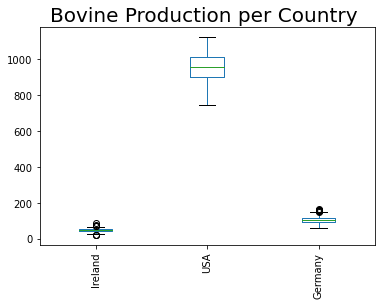

In [59]:
beef.plot(kind='box', rot=90)
plt.title('Bovine Production per Country ', fontsize=20);

## Bovine Plot

In [60]:
beef.iplot(color=[colorIreland, colorUSA, colorGermany],
                title = 'Bovine Meat Production in Ireland, Germany & USA Since 1992')
plt.show()

## Bovine Meat Growth Plot

In [61]:
(beef.iloc[-2] - beef.iloc[0]) / beef.iloc[0]

Ireland    0.5966
USA        0.1173
Germany   -0.3843
dtype: float64

In [62]:
((1 + beef.pct_change()).cumprod() - 1).iplot(color=[colorIreland, colorUSA, colorGermany],
                title = 'Bovine Meat Percentage Growth in Ireland, Germany & USA Since 1992')
plt.show()

## Bovine Meat Variance Plot

In [63]:
fig = px.bar(beef[200:-2].pct_change(), 
             labels={'value': 'Percentage Growth', 'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland', 
                  title_x=0.5, legend_title='Livestock')
#fig.update_traces(marker_color={'Ireland':colorIreland, 'USA':colorUSA, 'Germany':colorGermany})
fig.show()

In [64]:
beef[200:-2].pct_change().iplot(color=[colorIreland, colorUSA, colorGermany],
                       title = 'Bovine Meat Variance from Month to MOnght in Ireland, Germany & USA Since 1992')

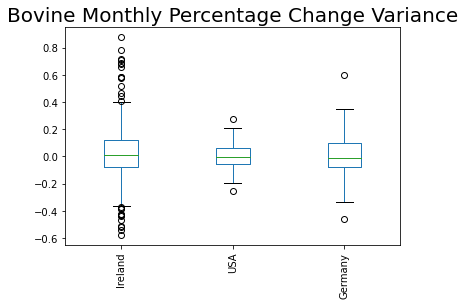

In [65]:
beef.pct_change().plot(kind='box', rot=90)
plt.title("Bovine Monthly Percentage Change Variance", fontsize=20);

# All Population Data

Merge all population data to compare one against the other in terms of growth of population.

In [66]:
allPopulationData = pd.concat([irelandPop, usaPop, germanyPop], axis=1)
allPopulationData

Ireland Population  USA Population  German Population
Date                                                             
1992-01-01        3558430.0000  256514000.0000      80624598.0000
1992-02-01        3559915.9167  256797750.0000      80668911.7500
1992-03-01        3561401.8333  257081500.0000      80713225.5000
1992-04-01        3562887.7500  257365250.0000      80757539.2500
1992-05-01        3564373.6667  257649000.0000      80801853.0000
...                        ...             ...                ...
2019-09-01        4974596.0000  329099399.6667      83191337.3333
2019-10-01        4979628.0000  329195580.5000      83203634.2500
2019-11-01        4984660.0000  329291761.3333      83215931.1667
2019-12-01        4989692.0000  329387942.1667      83228228.0833
2020-01-01        4994724.0000  329484123.0000      83240525.0000

[337 rows x 3 columns]

In [67]:
(allPopulationData.iloc[-1] - allPopulationData.iloc[0]) / allPopulationData.iloc[0] * 100

Ireland Population   40.3631
USA Population       28.4468
German Population     3.2446
dtype: float64

In [68]:
allPopulationData[['Ireland Population', 'USA Population', 'German Population']].pct_change().cumsum().iplot(
             color=[colorIreland, colorUSA, colorGermany],
            title = 'Populaiton Growth in Ireland, Germany & USA since 1992')
plt.show()

## Production Per Capita

In [69]:
bovineMeat = allData.copy()
bovineMeat.drop(bovineMeat.tail(len(allData) - len(irelandPop)).index, inplace=True)

bovineMeatData = pd.DataFrame()
bovineMeatData['Ireland Per Capita Bovine Meat Production'] = bovineMeat['Ireland Bovine Meat'].values / irelandPop['Ireland Population'].values * 1000000
bovineMeatData['USA Per Capita Bovine Meat Production'] = bovineMeat['USA Bovine Meat'].values / usaPop['USA Population'].values * 1000000
bovineMeatData['Germany Per Capita Bovine Meat Production'] = bovineMeat['Germany Bovine Meat'].values / germanyPop['German Population'].values * 1000000

In [70]:
(bovineMeatData.iloc[-1] - bovineMeatData.iloc[0]) / bovineMeatData.iloc[0] * 100

Ireland Per Capita Bovine Meat Production    14.2140
USA Per Capita Bovine Meat Production        -8.1659
Germany Per Capita Bovine Meat Production   -39.1485
dtype: float64

In [71]:
((1 + bovineMeatData.pct_change()).cumprod() - 1).iplot(color=[colorIreland, colorUSA, colorGermany], 
                        title = 'Bovine Meat Percentage Growth Per Capita in Ireland, Germany & USA Since 1992')

plt.show()

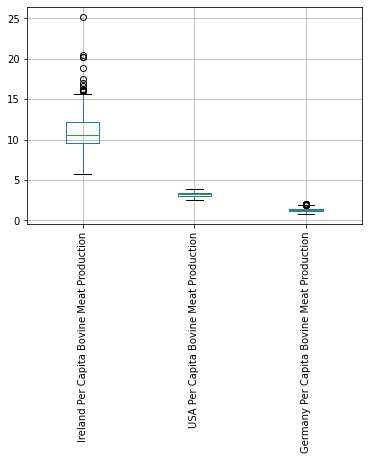

In [72]:
bovineMeatData.boxplot(rot=90);

# GDP Growth

In [73]:
allEco = pd.concat([irelandGDP, germanyGDP, usaGDP], axis=1)
allEco

Ireland GDP  Ireland GDP Per Capita        Germany GDP  \
Year                                                                      
1992-01-01  76486482000.0000              11727.6453 2261460000000.0000   
1992-02-01  76658105500.0000              11800.6422 2259619166666.6665   
1992-03-01  76829729000.0000              11873.6390 2257778333333.3335   
1992-04-01  77001352500.0000              11946.6358 2255937500000.0000   
1992-05-01  77172976000.0000              12019.6326 2254096666666.6665   
...                      ...                     ...                ...   
2019-09-01 347254666666.6667              73943.3529 3146116666666.6665   
2019-10-01 348888500000.0000              74154.5104 3133760000000.0000   
2019-11-01 350522333333.3333              74365.6678 3121403333333.3335   
2019-12-01 352156166666.6667              74576.8253 3109046666666.6665   
2020-01-01 353790000000.0000              74787.9827 3096690000000.0000   

            Germany GDP Per Capita             USA GDP  USA GDP Per Capita  
Year                                                                        
1992-01-01              21110.9270 10139200000000.0000          25418.9908  
1992-02-01              21149.5396 10162450000000.0000          25499.6827  
1992-03-01              21188.1523 10185700000000.0000          25580.3746  
1992-04-01              21226.7649 10208950000000.0000          25661.0665  
1992-05-01              21265.3776 10232200000000.0000          25741.7584  
...                            ...                 ...                 ...  
2019-09-01              40929.9411 19521166666666.6680          63897.5237  
2019-10-01              40821.0871 19464500000000.0000          63724.7731  
2019-11-01              40712.2332 19407833333333.3320          63552.0224  
2019-12-01              40603.3793 19351166666666.6680          63379.2717  
2020-01-01              40494.5254 19294500000000.0000          63206.5211  

[337 rows x 6 columns]

In [74]:
(allEco.iloc[-1] - allEco.iloc[0]) / allEco.iloc[0] * 100

Ireland GDP              362.5523
Ireland GDP Per Capita   537.7067
Germany GDP               36.9332
Germany GDP Per Capita    91.8178
USA GDP                   90.2961
USA GDP Per Capita       148.6587
dtype: float64

In [75]:
((1 + allEco.filter(items=allEco.columns[~allEco.columns.str.contains(
    "Capita",regex=True)]).pct_change()).cumprod() - 1).dropna().iplot(
    title = 'GDP Growth Ireland, Germany & USA Since 1992',
    color=[colorIreland, colorGermany, colorUSA])

plt.show()

In [76]:
((1 + allEco.filter(items=allEco.columns[allEco.columns.str.contains(
    "Capita",regex=True)]).pct_change()).cumprod() - 1).dropna().iplot(
    title = 'GDP Per Capita Growth Ireland, Germany & USA Since 1992',
    color=[colorIreland, colorGermany, colorUSA])

plt.show()

# Production vs GDP Per Capita

## Ireland

In [77]:
irelandProGDP = pd.concat([irelandGDP['Ireland GDP Per Capita'], irelandData['Ireland Bovine Meat']], axis=1)
irelandProGDP.dropna(inplace=True)
(irelandProGDP.iloc[-1] - irelandProGDP.iloc[0]) / irelandProGDP.iloc[0] * 100

Ireland GDP Per Capita   537.7067
Ireland Bovine Meat       60.3143
dtype: float64

In [78]:
((1 + irelandProGDP.pct_change()).cumprod() - 1).iplot(kind='line', yTitle='Percentage growth', 
                                                      xTitle='Date',  
                    title='Ireland Bovine Meat Production per Capita Since 1992',
                                                    color=[colorIreland, 'red'])
plt.show()

## Germany

In [79]:
germanyProGDP = pd.concat([germanyGDP['Germany GDP Per Capita'], germanData['Germany Bovine Meat']], axis=1)
germanyProGDP.dropna(inplace=True)
(germanyProGDP.iloc[-1] - germanyProGDP.iloc[0]) / germanyProGDP.iloc[0] * 100

Germany GDP Per Capita    91.8178
Germany Bovine Meat      -37.1741
dtype: float64

In [80]:
((1 + germanyProGDP.pct_change()).cumprod() - 1).iplot(kind='line', yTitle='Percentage growth', 
                                                      xTitle='Date',  
                                                       title='Germany Bovine Meat Production per Capita Since 1992',
                                                      color=[colorGermany, 'red'])

## USA

In [81]:
usaProGDP = pd.concat([usaGDP['USA GDP Per Capita'], usaData['USA Bovine Meat']], axis=1)
usaProGDP.dropna(inplace=True)
(usaProGDP.iloc[-1] - usaProGDP.iloc[0]) / usaProGDP.iloc[0] * 100

USA GDP Per Capita   148.6587
USA Bovine Meat       17.9580
dtype: float64

In [82]:
((1 + usaProGDP.pct_change()).cumprod() - 1).iplot(kind='line', yTitle='Percentage growth', 
                                                      xTitle='Date',  
                                    title='USA Bovine Meat Production per Capita Since 1992',
                                                      color=[colorUSA, 'red'])

# Trade

In [83]:
allTrade = pd.concat([irelandTrade, germanyTrade, usaTrade], axis=1)
allTrade

Element     Export Quantity  Import Quantity  Ireland Surplus  \
Year                                                            
1992-01-01       71485.0000        6630.0000       64855.0000   
1992-02-01       72090.0833        6511.4167       65578.6667   
1992-03-01       72695.1667        6392.8333       66302.3333   
1992-04-01       73300.2500        6274.2500       67026.0000   
1992-05-01       73905.3333        6155.6667       67749.6667   
...                     ...              ...              ...   
2019-09-01       35891.0000        6803.6667       29087.3333   
2019-10-01       35510.7500        6883.5000       28627.2500   
2019-11-01       35130.5000        6963.3333       28167.1667   
2019-12-01       34750.2500        7043.1667       27707.0833   
2020-01-01       34370.0000        7123.0000       27247.0000   

Element     Export Quantity  Import Quantity  Germany Surplus  \
Year                                                            
1992-01-01      499140.0000      139669.0000      359471.0000   
1992-02-01      489988.5833      138668.1667      351320.4167   
1992-03-01      480837.1667      137667.3333      343169.8333   
1992-04-01      471685.7500      136666.5000      335019.2500   
1992-05-01      462534.3333      135665.6667      326868.6667   
...                     ...              ...              ...   
2019-09-01      140333.6667      124401.0000       15932.6667   
2019-10-01      139381.2500      124207.7500       15173.5000   
2019-11-01      138428.8333      124014.5000       14414.3333   
2019-12-01      137476.4167      123821.2500       13655.1667   
2020-01-01      136524.0000      123628.0000       12896.0000   

Element     Export Quantity  Import Quantity  USA Surplus  
Year                                                       
1992-01-01       82105.0000       63513.0000   18592.0000  
1992-02-01       79726.9167       64245.9167   15481.0000  
1992-03-01       77348.8333       64978.8333   12370.0000  
1992-04-01       74970.7500       65711.7500    9259.0000  
1992-05-01       72592.6667       66444.6667    6148.0000  
...                     ...              ...          ...  
2019-09-01      124205.6667      122391.0000    1814.6667  
2019-10-01      123427.5000      123194.2500     233.2500  
2019-11-01      122649.3333      123997.5000   -1348.1667  
2019-12-01      121871.1667      124800.7500   -2929.5833  
2020-01-01      121093.0000      125604.0000   -4511.0000  

[337 rows x 9 columns]

## Trade Surplus Plot

In [84]:
allTrade[['Ireland Surplus', 'Germany Surplus', 'USA Surplus']].iplot(kind='line', yTitle='Percentage growth', 
            xTitle='Date',  title='Trade Bovine Meat Surplus in Ireland, Germany and USA Since 1992',
            color=[colorIreland, colorGermany, colorUSA])

plt.show()

## Trade Surplus Growth Plot

In [85]:
((1 + allTrade[['Ireland Surplus', 'Germany Surplus', 'USA Surplus']].pct_change()).cumprod() - 1).iplot(kind='line', yTitle='Percentage growth', 
            xTitle='Date',  title='Trade Bovine Meat Surplus Growth Change in Ireland, Germany and USA Since 1992',
            color=[colorIreland, colorGermany, colorUSA])

plt.show()

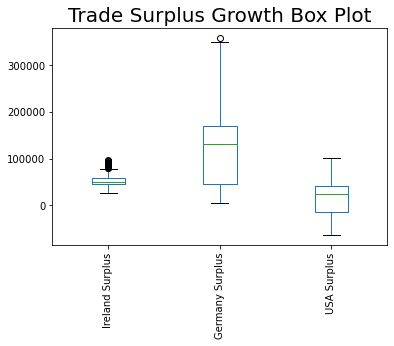

In [86]:
allTrade[['Ireland Surplus', 'Germany Surplus', 'USA Surplus']].plot(kind='box', rot=90)
plt.title('Trade Surplus Growth Box Plot', fontsize=20);

# Bovine Yield Growth Plot

In [87]:
beefProduction = pd.concat([irelandYield, germanyYield, usaYield], axis=1)

((1 + beefProduction.pct_change()).cumprod() - 1).iplot(kind='line', yTitle='Percentage growth', 
            xTitle='Date',  title='Bovine Meat Carcass Yield in Ireland, Germany and USA Since 1992',
            color=[colorIreland, colorGermany, colorUSA])

plt.show()

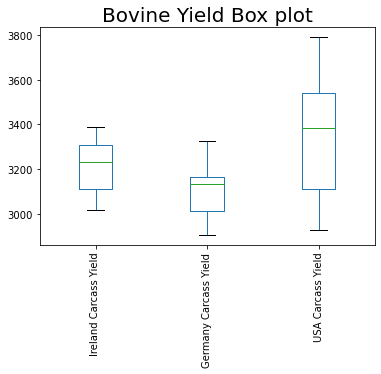

In [88]:
beefProduction.plot(kind='box', rot=90)
plt.title('Bovine Yield Box plot', fontsize=20);

# Prepare Data For Machine Learning Model

Merge individual country datasets into one dataset per country.  This will be preprocssing of the data just before feature engineering, imputing and scaling. 

### Ireland

In [89]:
irelandAllData = pd.concat([irelandGDP, irelandYield, irelandPop, 
                            irelandTrade, prices, irelandData], axis=1).dropna()
irelandAllData

Ireland GDP  Ireland GDP Per Capita  Ireland Carcass Yield  \
1992-01-01  76486482000.0000              11727.6453              3309.0000   
1992-02-01  76658105500.0000              11800.6422              3308.5000   
1992-03-01  76829729000.0000              11873.6390              3308.0000   
1992-04-01  77001352500.0000              11946.6358              3307.5000   
1992-05-01  77172976000.0000              12019.6326              3307.0000   
...                      ...                     ...                    ...   
2019-09-01 347254666666.6667              73943.3529              3359.3333   
2019-10-01 348888500000.0000              74154.5104              3361.0000   
2019-11-01 350522333333.3333              74365.6678              3362.6667   
2019-12-01 352156166666.6667              74576.8253              3364.3333   
2020-01-01 353790000000.0000              74787.9827              3366.0000   

            Ireland Population  Export Quantity  Import Quantity  \
1992-01-01        3558430.0000       71485.0000        6630.0000   
1992-02-01        3559915.9167       72090.0833        6511.4167   
1992-03-01        3561401.8333       72695.1667        6392.8333   
1992-04-01        3562887.7500       73300.2500        6274.2500   
1992-05-01        3564373.6667       73905.3333        6155.6667   
...                        ...              ...              ...   
2019-09-01        4974596.0000       35891.0000        6803.6667   
2019-10-01        4979628.0000       35510.7500        6883.5000   
2019-11-01        4984660.0000       35130.5000        6963.3333   
2019-12-01        4989692.0000       34750.2500        7043.1667   
2020-01-01        4994724.0000       34370.0000        7123.0000   

            Ireland Surplus  Price  Ireland Bovine Meat  Ireland Pig Meat  \
1992-01-01       64855.0000 2.5150              35.0000           17.9000   
1992-02-01       65578.6667 2.4650              31.9000           15.0000   
1992-03-01       66302.3333 2.4151              46.7000           16.5000   
1992-04-01       67026.0000 2.3651              40.0000           16.0000   
1992-05-01       67749.6667 2.3803              33.8000           15.9000   
...                     ...    ...                  ...               ...   
2019-09-01       29087.3333 5.0410              32.9700           24.4600   
2019-10-01       28627.2500 5.3036              61.8200           26.2000   
2019-11-01       28167.1667 5.0343              59.8900           26.2900   
2019-12-01       27707.0833 4.7650              48.2500           23.6800   
2020-01-01       27247.0000 4.4957              56.1100           28.3300   

            Ireland Lamb Meat  
1992-01-01             6.5000  
1992-02-01             5.3000  
1992-03-01             4.7000  
1992-04-01             5.9000  
1992-05-01             7.9000  
...                       ...  
2019-09-01             5.2800  
2019-10-01             6.6900  
2019-11-01             6.1200  
2019-12-01             5.8100  
2020-01-01             5.6100  

[337 rows x 11 columns]

### Germany

In [90]:
germanyAllData = pd.concat([germanyGDP, germanyYield, germanyPop, 
                            germanyTrade, prices, germanData], axis=1).dropna()
germanyAllData

Germany GDP  Germany GDP Per Capita  Germany Carcass Yield  \
1992-01-01 2261460000000.0000              21110.9270              2905.0000   
1992-02-01 2259619166666.6665              21149.5396              2908.5833   
1992-03-01 2257778333333.3335              21188.1523              2912.1667   
1992-04-01 2255937500000.0000              21226.7649              2915.7500   
1992-05-01 2254096666666.6665              21265.3776              2919.3333   
...                       ...                     ...                    ...   
2019-09-01 3146116666666.6665              40929.9411              3301.0000   
2019-10-01 3133760000000.0000              40821.0871              3307.0000   
2019-11-01 3121403333333.3335              40712.2332              3313.0000   
2019-12-01 3109046666666.6665              40603.3793              3319.0000   
2020-01-01 3096690000000.0000              40494.5254              3325.0000   

            German Population  Export Quantity  Import Quantity  \
1992-01-01      80624598.0000      499140.0000      139669.0000   
1992-02-01      80668911.7500      489988.5833      138668.1667   
1992-03-01      80713225.5000      480837.1667      137667.3333   
1992-04-01      80757539.2500      471685.7500      136666.5000   
1992-05-01      80801853.0000      462534.3333      135665.6667   
...                       ...              ...              ...   
2019-09-01      83191337.3333      140333.6667      124401.0000   
2019-10-01      83203634.2500      139381.2500      124207.7500   
2019-11-01      83215931.1667      138428.8333      124014.5000   
2019-12-01      83228228.0833      137476.4167      123821.2500   
2020-01-01      83240525.0000      136524.0000      123628.0000   

            Germany Surplus  Price  Germany Bovine Meat  Germany Pig Meat  \
1992-01-01      359471.0000 2.5150             159.1700          323.2400   
1992-02-01      351320.4167 2.4650             140.1100          285.4000   
1992-03-01      343169.8333 2.4151             164.5400          316.9800   
1992-04-01      335019.2500 2.3651             155.6100          297.4600   
1992-05-01      326868.6667 2.3803             144.8200          300.1500   
...                     ...    ...                  ...               ...   
2019-09-01       15932.6667 5.0410              93.0000          440.0000   
2019-10-01       15173.5000 5.3036             103.0000          468.0000   
2019-11-01       14414.3333 5.0343             111.0000          460.0000   
2019-12-01       13655.1667 4.7650              89.0000          414.0000   
2020-01-01       12896.0000 4.4957             100.0000          470.0000   

            Germany Lamb Meat  
1992-01-01             2.9100  
1992-02-01             2.5200  
1992-03-01             3.1600  
1992-04-01             3.6500  
1992-05-01             2.7000  
...                       ...  
2019-09-01             2.0000  
2019-10-01             2.0000  
2019-11-01             2.0000  
2019-12-01             2.0000  
2020-01-01             2.0000  

[337 rows x 11 columns]

### USA

In [91]:
usaAllData = pd.concat([usaGDP, usaYield, usaPop, 
                            usaTrade, prices, usaData], axis=1).dropna()
usaAllData

USA GDP  USA GDP Per Capita  USA Carcass Yield  \
1992-01-01 10139200000000.0000          25418.9908          3014.0000   
1992-02-01 10162450000000.0000          25499.6827          3014.0000   
1992-03-01 10185700000000.0000          25580.3746          3014.0000   
1992-04-01 10208950000000.0000          25661.0665          3014.0000   
1992-05-01 10232200000000.0000          25741.7584          3014.0000   
...                        ...                 ...                ...   
2019-09-01 19521166666666.6680          63897.5237          3670.6667   
2019-10-01 19464500000000.0000          63724.7731          3679.0000   
2019-11-01 19407833333333.3320          63552.0224          3687.3333   
2019-12-01 19351166666666.6680          63379.2717          3695.6667   
2020-01-01 19294500000000.0000          63206.5211          3704.0000   

            USA Population  Export Quantity  Import Quantity  USA Surplus  \
1992-01-01  256514000.0000       82105.0000       63513.0000   18592.0000   
1992-02-01  256797750.0000       79726.9167       64245.9167   15481.0000   
1992-03-01  257081500.0000       77348.8333       64978.8333   12370.0000   
1992-04-01  257365250.0000       74970.7500       65711.7500    9259.0000   
1992-05-01  257649000.0000       72592.6667       66444.6667    6148.0000   
...                    ...              ...              ...          ...   
2019-09-01  329099399.6667      124205.6667      122391.0000    1814.6667   
2019-10-01  329195580.5000      123427.5000      123194.2500     233.2500   
2019-11-01  329291761.3333      122649.3333      123997.5000   -1348.1667   
2019-12-01  329387942.1667      121871.1667      124800.7500   -2929.5833   
2020-01-01  329484123.0000      121093.0000      125604.0000   -4511.0000   

            Price  USA Bovine Meat  USA Pig Meat  USA Lamb Meat  
1992-01-01 2.5150         906.2776      676.3062        13.6078  
1992-02-01 2.4650         757.9529      589.6701        12.2470  
1992-03-01 2.4151         821.9094      651.3586        14.5150  
1992-04-01 2.3651         794.2402      628.2254        14.5150  
1992-05-01 2.3803         846.8570      571.9800        10.8862  
...           ...              ...           ...            ...  
2019-09-01 5.0410         980.0317     1009.4245         4.3998  
2019-10-01 5.3036        1090.3907     1176.3465         5.2163  
2019-11-01 5.0343        1030.5165     1097.2399         4.6266  
2019-12-01 4.7650        1015.6840     1103.4995         4.9895  
2020-01-01 4.4957        1069.0265     1153.5308         4.9442  

[337 rows x 11 columns]

# Descriptive Statistics

In this section statistics will be done on all the data for each country.  Additionally the datasets will be checked for normal distributions and compared with the proper statistical test.  This will allow for acceptance or rejection of null hypothesis.


https://www.statology.org/python-guides/
https://pingouin-stats.org/api.html


In [92]:
import pingouin as pg

## Ireland

In [93]:
irelandAllData.describe()

Ireland GDP  Ireland GDP Per Capita  Ireland Carcass Yield  \
count          337.0000                337.0000               337.0000   
mean  183252997913.9466              37539.1028              3214.9184   
std    71261498532.1322              16453.9733               112.2077   
min    76486482000.0000              11727.6453              3018.0000   
25%   130485000000.0000              24712.6007              3112.3333   
50%   187426333333.3333              37709.4495              3230.0000   
75%   202103000000.0000              43651.9599              3309.2500   
max   353790000000.0000              74787.9827              3388.0000   

       Ireland Population  Export Quantity  Import Quantity  Ireland Surplus  \
count            337.0000         337.0000         337.0000         337.0000   
mean         4230366.2819       58341.3694        6073.7641       52267.6053   
std           464416.0490       11742.4748        2676.7195       12830.7570   
min          3558430.0000       34370.0000          97.0000       27247.0000   
25%          3754786.0000       50600.1667        4485.0000       44733.0000   
50%          4273591.0000       56908.9167        6093.0000       50424.0000   
75%          4623816.0000       63288.0000        7778.2500       58111.0000   
max          4994724.0000       98538.0000       13568.0000       96894.0000   

         Price  Ireland Bovine Meat  Ireland Pig Meat  Ireland Lamb Meat  
count 337.0000             337.0000          337.0000           337.0000  
mean    2.9396              46.3696           19.5099             5.8798  
std     1.0203               8.8794            3.0352             1.7486  
min     1.6622              20.8000           14.1000             2.0000  
25%     2.0158              41.0200           17.2000             4.6000  
50%     2.6004              46.2900           18.7000             5.6000  
75%     3.9977              51.5000           21.6200             6.9000  
max     5.6440              90.0000           29.7000            10.3000

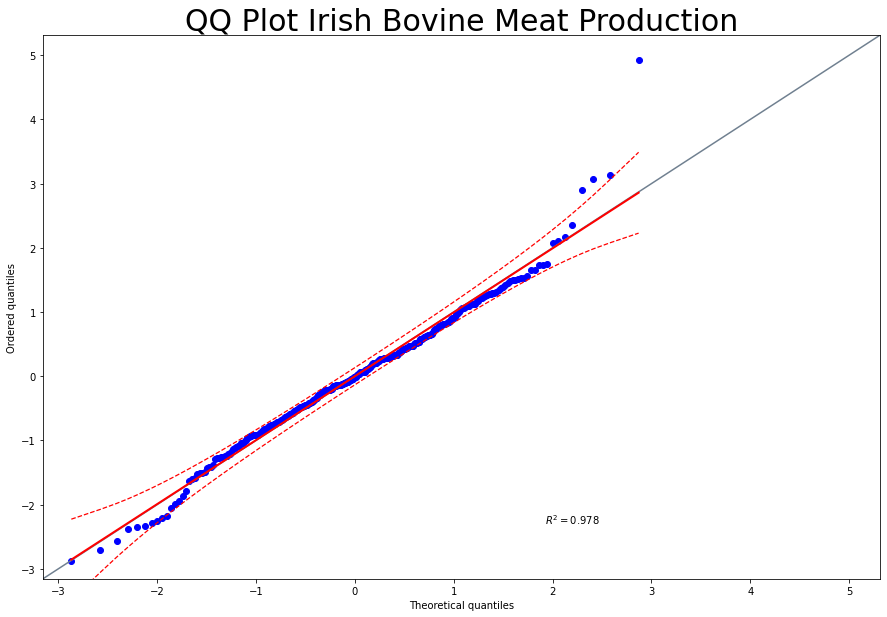

<Figure size 432x288 with 0 Axes>

In [94]:
#Normality plot. Our variable is "charges"
ax = pg.qqplot(irelandAllData['Ireland Bovine Meat'], figsize=(15,10))
plt.title("QQ Plot Irish Bovine Meat Production", fontsize=30)
plt.figure();

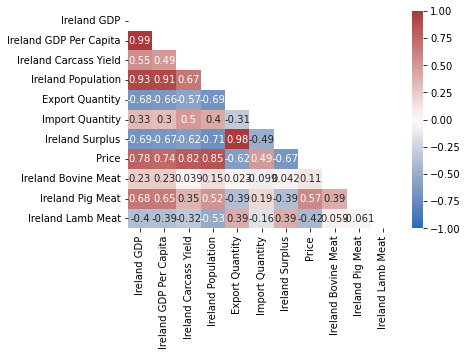

In [95]:
mask = np.triu(np.ones_like(irelandAllData.corr(), dtype=bool))
sns.heatmap(irelandAllData.corr(), annot=True, vmax=1, vmin=-1, center=0, mask = mask, cmap='vlag')
plt.show();

In [96]:
#ProfileReport(irelandAllData)

In [97]:
#sns.pairplot(irelandAllData)

## Germany

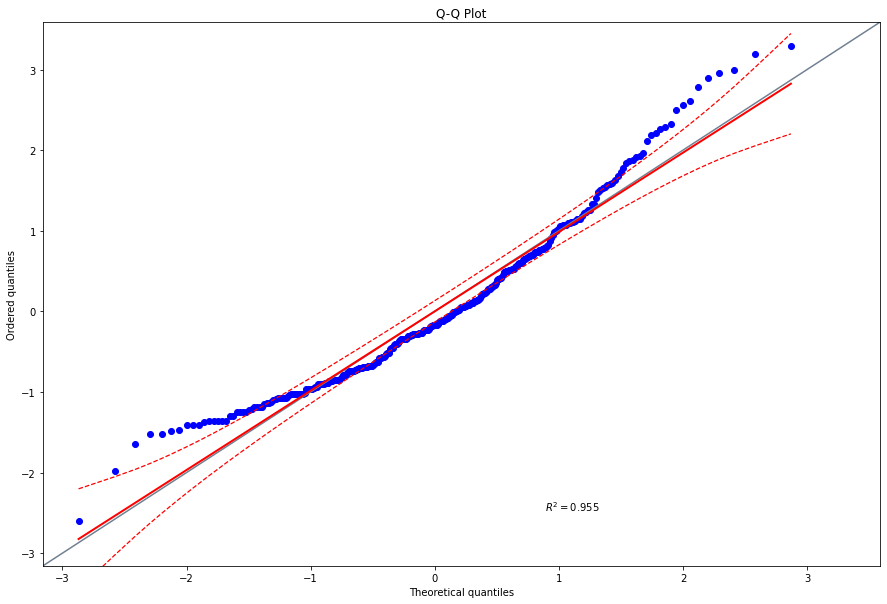

<Figure size 432x288 with 0 Axes>

In [98]:
#Normality plot. Our variable is "charges"
ax = pg.qqplot(germanyAllData['Germany Bovine Meat'], figsize=(15,10))
plt.figure();

In [99]:
germanyAllData.describe()

Germany GDP  Germany GDP Per Capita  Germany Carcass Yield  \
count           337.0000                337.0000               337.0000   
mean  2714755771513.3530              30109.7528              3096.8754   
std    291356466367.3461               6046.2145               100.5342   
min   2239370000000.0000              21110.9270              2905.0000   
25%   2483280000000.0000              25084.9440              3012.0000   
50%   2691383333333.3335              28953.4202              3135.0000   
75%   2917240000000.0000              34860.5482              3166.4167   
max   3244970000000.0000              41800.7725              3325.0000   

       German Population  Export Quantity  Import Quantity  Germany Surplus  \
count           337.0000         337.0000         337.0000         337.0000   
mean       81940129.0312      214407.0623       92287.6988      122119.3635   
std          723563.6261       63496.3550       43315.3767       73854.0014   
min        80274983.0000      136524.0000       23437.0000        5268.0000   
25%        81526605.5000      176936.0000       47694.3333       46622.3333   
50%        82075465.3333      201530.6667       94874.0833      131788.5000   
75%        82453926.8333      232350.0000      136919.0000      169628.8333   
max        83240525.0000      499140.0000      153050.0000      359471.0000   

         Price  Germany Bovine Meat  Germany Pig Meat  Germany Lamb Meat  
count 337.0000             337.0000          337.0000           337.0000  
mean    2.9396             106.0945          386.0739             2.9109  
std     1.0203              17.7787           65.7352             1.3047  
min     1.6622              59.9300          265.0700             1.0000  
25%     2.0158              93.0000          324.0400             2.0000  
50%     2.6004             103.0000          383.4100             2.6900  
75%     3.9977             116.4300          446.0000             3.5900  
max     5.6440             164.5400          504.0000             7.7300

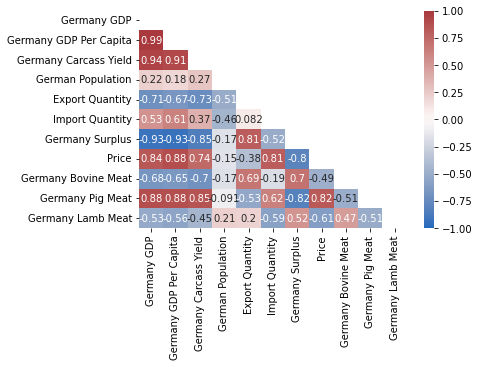

In [100]:
mask = np.triu(np.ones_like(germanyAllData.corr(), dtype=bool))
sns.heatmap(germanyAllData.corr(), annot=True, vmax=1, vmin=-1, center=0, mask = mask, cmap='vlag')
plt.show();

In [101]:
#sns.pairplot(germanyAllData)

In [102]:
#ProfileReport(germanyAllData)

## USA

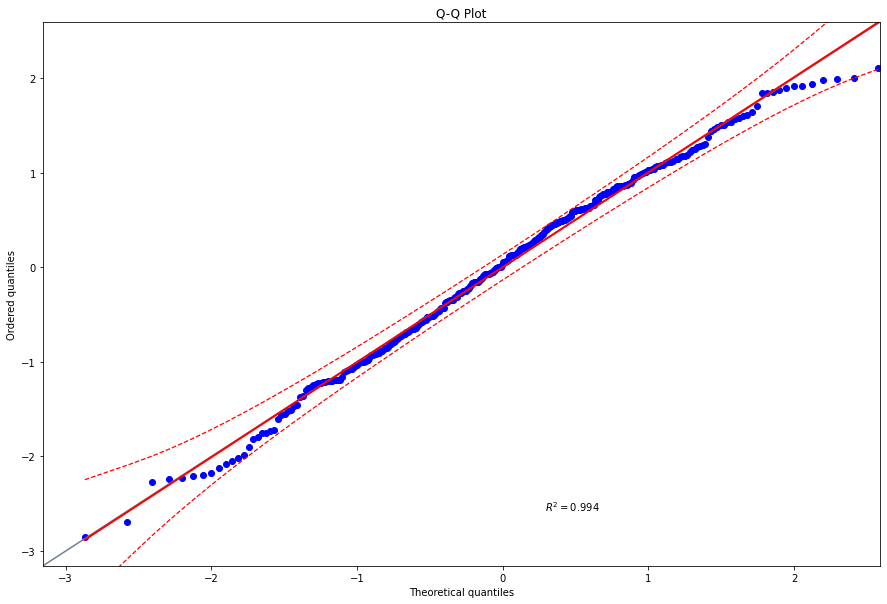

<Figure size 432x288 with 0 Axes>

In [103]:
#Normality plot. Our variable is "charges"
ax = pg.qqplot(usaAllData['USA Bovine Meat'], figsize=(15,10))
plt.figure();

In [104]:
usaAllData.describe()

USA GDP  USA GDP Per Capita  USA Carcass Yield  \
count            337.0000            337.0000           337.0000   
mean  15289187685459.9414          44424.6492          3351.5579   
std    2784128131668.9365          11526.1355           245.1709   
min   10139200000000.0000          25418.9908          2929.0000   
25%   13193600000000.0000          34513.5615          3112.2500   
50%   15946616666666.6660          46298.7314          3383.0000   
75%   17258200000000.0000          53106.5368          3539.0000   
max   19974500000000.0000          65279.5290          3791.0000   

       USA Population  Export Quantity  Import Quantity  USA Surplus    Price  \
count        337.0000         337.0000         337.0000     337.0000 337.0000   
mean   296997587.3220       90485.1128       75780.3694   14704.7433   2.9396   
std     21612764.1152       37553.1375       33671.1589   36284.5119   1.0203   
min    256514000.0000        5070.0000       13883.0000  -64484.0000   1.6622   
25%    279040000.0000       68455.4167       49801.0000  -14452.3333   2.0158   
50%    298379912.0000       98785.8333       76032.5000   25188.6667   2.6004   
75%    316059947.0000      121657.5000      101700.2500   41027.5000   3.9977   
max    329484123.0000      137348.0000      142129.0000  102163.0000   5.6440   

       USA Bovine Meat  USA Pig Meat  USA Lamb Meat  
count         337.0000      337.0000       337.0000  
mean          953.3250      794.6790         7.4385  
std            72.5573      128.0148         2.3766  
min           746.6130      537.0534         4.3998  
25%           901.7870      690.8212         5.5338  
50%           957.3521      786.5292         6.6678  
75%          1007.9276      889.2678         8.6183  
max          1122.1875     1176.3465        15.4221

In [105]:
#sns.pairplot(usaAllData)

In [106]:
#ProfileReport(usaAllData)

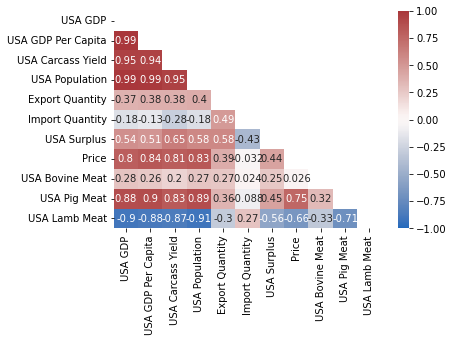

In [107]:
# Only plot the highly correlated data or half the correlation matrix
#https://datagy.io/python-correlation-matrix/
mask = np.triu(np.ones_like(usaAllData.corr(), dtype=bool))
sns.heatmap(usaAllData.corr(), annot=True, vmax=1, vmin=-1, center=0, mask = mask, cmap='vlag')
plt.show();

## All Data

In [108]:
allData.describe()

Ireland Bovine Meat  Ireland Pig Meat  Ireland Lamb Meat  \
count             348.0000          348.0000           348.0000   
mean               46.5627           19.7318             5.8681   
std                 8.8600            3.2418             1.7268   
min                20.8000           14.1000             2.0000   
25%                41.1450           17.2775             4.6625   
50%                46.5900           18.8000             5.5750   
75%                51.9100           21.8100             6.9000   
max                90.0000           29.7000            10.3000   

       USA Bovine Meat  USA Pig Meat  USA Lamb Meat  Germany Bovine Meat  \
count         348.0000      348.0000       348.0000             348.0000   
mean          954.9707      802.9415         7.3496             105.5858   
std            73.9692      135.0644         2.3908              17.7737   
min           746.6130      537.0534         4.1730              59.9300   
25%           903.1137      696.2643         5.4318              92.6500   
50%           957.6469      791.0651         6.5998             102.7950   
75%          1010.6378      899.6438         8.6183             115.9625   
max          1122.1875     1176.3465        15.4221             164.5400   

       Germany Pig Meat  Germany Lamb Meat  
count          348.0000           348.0000  
mean           387.2095             2.8878  
std             65.0466             1.2920  
min            265.0700             1.0000  
25%            325.0750             2.0000  
50%            396.2750             2.6650  
75%            445.2500             3.5600  
max            504.0000             7.7300

## Ireland and Germany Bland Altman Plot

In this plot Ireland and Germany's mean and testing within 2 standard deviations. This is an additional statistical measurement to show what correlation or regression might not show.  This was an interesting test and easy to interpret.  Ireland and Germany are showing good agreement

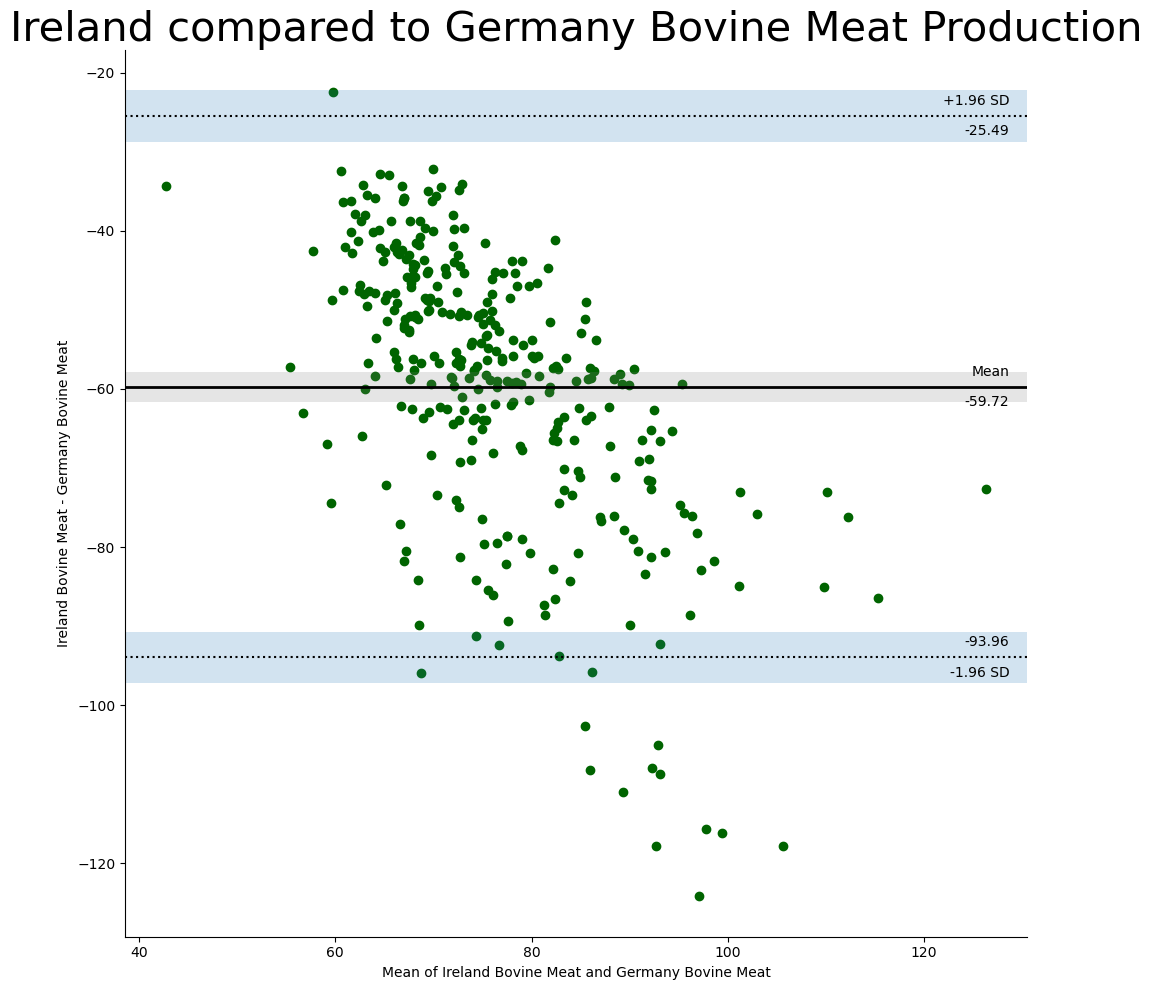

In [109]:
#https://pingouin-stats.org/generated/pingouin.plot_blandaltman.html#pingouin.plot_blandaltman
ax = pg.plot_blandaltman(irelandAllData['Ireland Bovine Meat'], germanyAllData['Germany Bovine Meat'], 
                         figsize=(10,10), scatter_kws={'color': colorIreland})
plt.title('Ireland compared to Germany Bovine Meat Production', fontsize=30)
plt.tight_layout();

## Ireland and USA Bland Altman Plot

In this plot Ireland and USA's mean and testing within 2 standard deviations. This is an additional statistical measurement to show what correlation or regression might not show.  This was an interesting test and easy to interpret.  Ireland and USA are showing a lack of agreement

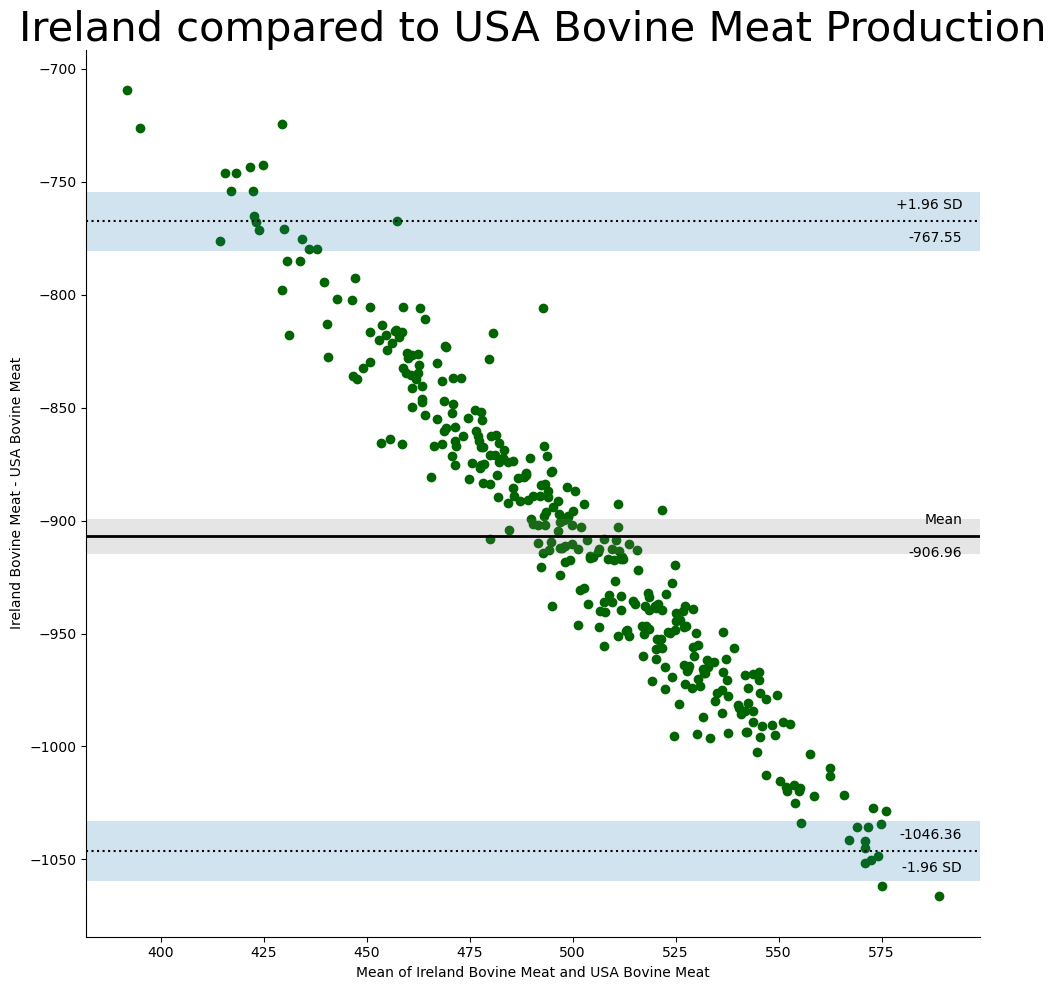

In [110]:
ax = pg.plot_blandaltman(irelandAllData['Ireland Bovine Meat'], 
                         usaAllData['USA Bovine Meat'], figsize=(10,10),
                        scatter_kws={'color': colorIreland})
plt.title('Ireland compared to USA Bovine Meat Production', fontsize=30)
plt.tight_layout();

## Plot Shift Ireland Vs Germany

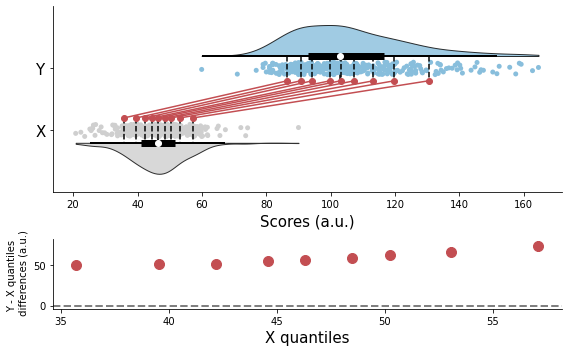

In [111]:
# Plot shift
#https://pingouin-stats.org/generated/pingouin.plot_shift.html
#pingouin.plot_shift
# Ireland is X and Germany is Y
fig = pg.plot_shift(irelandAllData['Ireland Bovine Meat'], germanyAllData['Germany Bovine Meat'])

## Plot Shift Ireland Vs USA

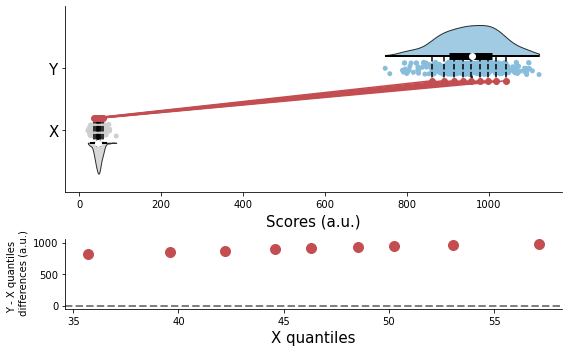

In [112]:
# Ireland is X and USA is Y
fig = pg.plot_shift(irelandAllData['Ireland Bovine Meat'], usaAllData['USA Bovine Meat'])

In [113]:
#sns.set(style='darkgrid', font_scale=1.2)

#g = pg.plot_rm_corr(data=irelandAllData, x='Ireland Bovine Meat', y='Ireland GDP Per Capita',
#                    subject='Price', legend=False,
#                    kwargs_facetgrid=dict(height=4.5, aspect=1.5,
#                                          palette='Spectral'))

# Normal Distribution and Null Hypothesis Tests

## Irleland and Germany

In [114]:
fn.Stats.distribution(beef[['Ireland','Germany']])

Ireland not normal distribution, pvalue = 0.000218

Germany not normal distribution, pvalue = 0.000000

Reject Null Hypothesis P-Value 0.0000


MannwhitneyuResult(statistic=83.5, pvalue=4.651183231644249e-115)

## Ireland and USA

In [115]:
fn.Stats.distribution(beef[['Ireland','USA']])

Ireland not normal distribution, pvalue = 0.000218

USA not normal distribution, pvalue = 0.043295

Reject Null Hypothesis P-Value 0.0000


MannwhitneyuResult(statistic=0.0, pvalue=2.2700291563892367e-115)

## All Countries Statistical Inference

In [116]:
fn.Stats.distribution(beef)

Ireland not normal distribution, pvalue = 0.000218

USA not normal distribution, pvalue = 0.043295

Germany not normal distribution, pvalue = 0.000000

Accept Null Hypothesis P-Value 0.3679


KruskalResult(statistic=2.0, pvalue=0.36787944117144245)

## Ireland All Stats

In [117]:
fn.Stats.distribution(irelandAllData)

Ireland GDP not normal distribution, pvalue = 0.000000

Ireland GDP Per Capita not normal distribution, pvalue = 0.000000

Ireland Carcass Yield not normal distribution, pvalue = 0.000000

Ireland Population not normal distribution, pvalue = 0.000000

Export Quantity not normal distribution, pvalue = 0.000000

Import Quantity not normal distribution, pvalue = 0.000061

Ireland Surplus not normal distribution, pvalue = 0.000000

Price not normal distribution, pvalue = 0.000000

Ireland Bovine Meat not normal distribution, pvalue = 0.000159

Ireland Pig Meat not normal distribution, pvalue = 0.000000

Ireland Lamb Meat not normal distribution, pvalue = 0.000001

Accept Null Hypothesis P-Value 0.4405


KruskalResult(statistic=10.0, pvalue=0.44049328506521257)

## Germany All Stats

In [118]:
fn.Stats.distribution(germanyAllData)

Germany GDP not normal distribution, pvalue = 0.000000

Germany GDP Per Capita not normal distribution, pvalue = 0.000000

Germany Carcass Yield not normal distribution, pvalue = 0.000000

German Population not normal distribution, pvalue = 0.000000

Export Quantity not normal distribution, pvalue = 0.000000

Import Quantity not normal distribution, pvalue = 0.000000

Germany Surplus not normal distribution, pvalue = 0.000000

Price not normal distribution, pvalue = 0.000000

Germany Bovine Meat not normal distribution, pvalue = 0.000000

Germany Pig Meat not normal distribution, pvalue = 0.000000

Germany Lamb Meat not normal distribution, pvalue = 0.000000

Accept Null Hypothesis P-Value 0.4405


KruskalResult(statistic=10.0, pvalue=0.44049328506521257)

## USA All Stats

In [119]:
fn.Stats.distribution(usaAllData)

USA GDP not normal distribution, pvalue = 0.000000

USA GDP Per Capita not normal distribution, pvalue = 0.000000

USA Carcass Yield not normal distribution, pvalue = 0.000000

USA Population not normal distribution, pvalue = 0.000000

Export Quantity not normal distribution, pvalue = 0.000000

Import Quantity not normal distribution, pvalue = 0.000000

USA Surplus not normal distribution, pvalue = 0.000001

Price not normal distribution, pvalue = 0.000000

USA Bovine Meat normal distribution, pvalue = 0.087712

USA Pig Meat not normal distribution, pvalue = 0.000172

USA Lamb Meat not normal distribution, pvalue = 0.000000

Accept Null Hypothesis P-Value 0.4405


KruskalResult(statistic=10.0, pvalue=0.44049328506521257)

# Probability Distribution

## Ireand Probability Distribution

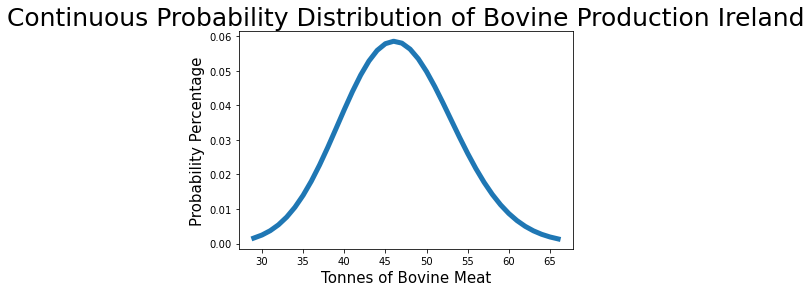

In [120]:
from scipy.stats import poisson, norm
# https://www.alphacodingskills.com/scipy/scipy-poisson-distribution.php
mu = beef['Ireland'].mean()
x = np.arange(0, int(mu+mu), 1)
y = poisson.pmf(x, mu, 0)

plt.plot(x[y>0.001], y[y>0.001],lw=5) 
plt.title('Continuous Probability Distribution of Bovine Production Ireland', fontsize=25)
plt.ylabel('Probability Percentage', fontsize=15)
plt.xlabel('Tonnes of Bovine Meat', fontsize=15)
plt.show()

In [121]:
# Verify sum equal 1
sum(y)

0.9999999986346457

## Germany Probability Distribution

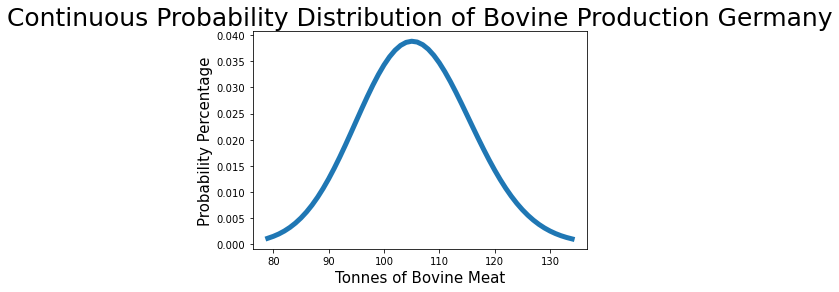

In [122]:
# https://www.alphacodingskills.com/scipy/scipy-poisson-distribution.php
mu = beef['Germany'].mean()
x = np.arange(0, int(mu+mu), 1)
y = poisson.pmf(x, mu, 0)

plt.plot(x[y>0.001], y[y>0.001],lw=5) 
plt.title('Continuous Probability Distribution of Bovine Production Germany', fontsize=25)
plt.ylabel('Probability Percentage', fontsize=15)
plt.xlabel('Tonnes of Bovine Meat', fontsize=15)
plt.show()

## USA Probability Distribution

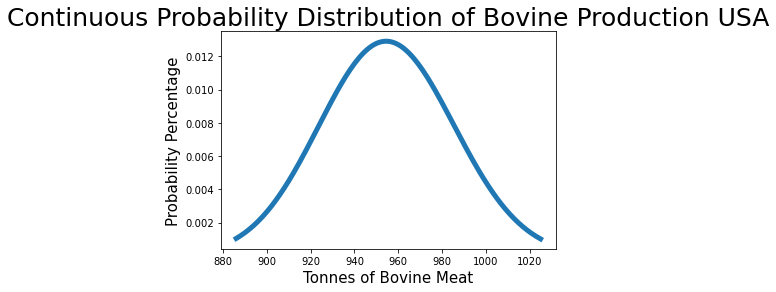

In [123]:
# https://www.alphacodingskills.com/scipy/scipy-poisson-distribution.php
mu = beef['USA'].mean()
x = np.arange(0, int(mu+mu), 1)
y = poisson.pmf(x, mu, 0)

plt.plot(x[y>0.001], y[y>0.001],lw=5) 
plt.title('Continuous Probability Distribution of Bovine Production USA', fontsize=25)
plt.ylabel('Probability Percentage', fontsize=15)
plt.xlabel('Tonnes of Bovine Meat', fontsize=15)
plt.show()

## Logrithmic Plot Ireland and Germany

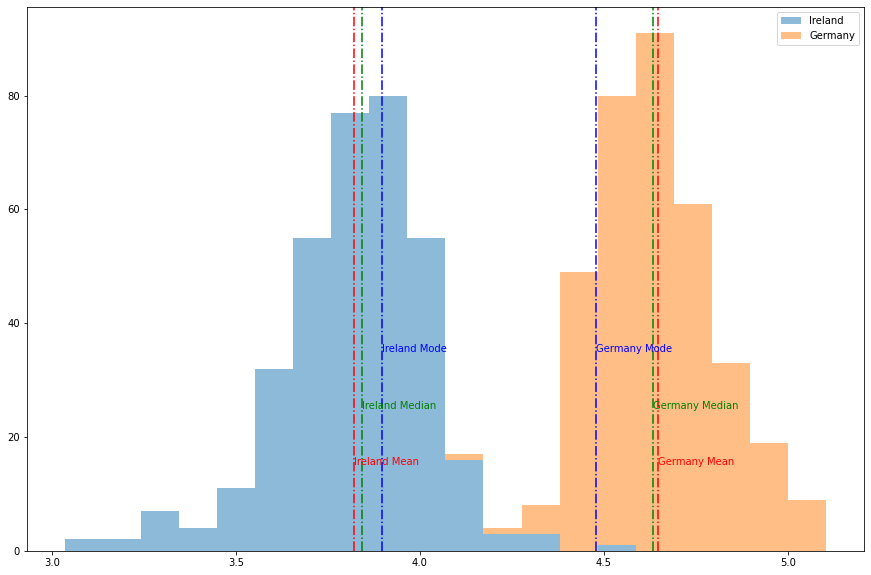

In [124]:
from statistics import median, mode

plt.figure(figsize=(15,10))
normal = (np.log(beef[['Ireland', 'Germany']]).replace([np.inf, -np.inf]))

plt.axvline(normal['Ireland'].mean(), color='red', linestyle='-.')
plt.text(normal['Ireland'].mean(), 15, 'Ireland Mean', color='red')
plt.axvline(median(normal['Ireland']), color='green', linestyle='-.')
plt.text(median(normal['Ireland']),25, 'Ireland Median', color='green')
plt.axvline(mode(normal['Ireland']), color='blue', linestyle='-.')
plt.text(mode(normal['Ireland']),35, 'Ireland Mode', color='blue')

plt.axvline(normal['Germany'].mean(), color='red', linestyle='-.')
plt.text(normal['Germany'].mean(), 15, 'Germany Mean', color='red')
plt.axvline(median(normal['Germany']), color='green', linestyle='-.')
plt.text(median(normal['Germany']),25, 'Germany Median', color='green')
plt.axvline(mode(normal['Germany']), color='blue', linestyle='-.')
plt.text(mode(normal['Germany']),35, 'Germany Mode', color='blue')


plt.hist((np.log(beef[['Ireland', 'Germany']]).replace([np.inf, -np.inf])), 
         label=['Ireland', 'Germany'], stacked=True, bins=20, alpha=0.5)
plt.legend(loc=0)
plt.show()

## Normal Distribution Probability Prediction

In [125]:
# Normal Distribution Probablity Prediction
mean = normal[['Ireland']].mean()
std = normal[['Ireland']].std()
  
probability_pdf = norm.pdf(3.83, loc=mean, scale=std)
print(probability_pdf)

[1.99767935]


# Data PreProcessing

In [126]:
data = fn.dataProcessing(irelandAllData.copy(), 'Ireland Bovine Meat', 12)
data.targetIntoLast()
data.addMonth()
data.highLow()
data.movingAverage()
data.removeOutliers()
data.data

Month       Ireland GDP  Ireland GDP Per Capita  \
1992-01-01     1  76486482000.0000              11727.6453   
1992-02-01     2  76658105500.0000              11800.6422   
1992-03-01     3  76829729000.0000              11873.6390   
1992-04-01     4  77001352500.0000              11946.6358   
1992-05-01     5  77172976000.0000              12019.6326   
...          ...               ...                     ...   
2019-09-01     9 347254666666.6667              73943.3529   
2019-10-01    10 348888500000.0000              74154.5104   
2019-11-01    11 350522333333.3333              74365.6678   
2019-12-01    12 352156166666.6667              74576.8253   
2020-01-01     1 353790000000.0000              74787.9827   

            Ireland Carcass Yield  Ireland Population  Export Quantity  \
1992-01-01              3309.0000        3558430.0000       71485.0000   
1992-02-01              3308.5000        3559915.9167       72090.0833   
1992-03-01              3308.0000        3561401.8333       72695.1667   
1992-04-01              3307.5000        3562887.7500       73300.2500   
1992-05-01              3307.0000        3564373.6667       73905.3333   
...                           ...                 ...              ...   
2019-09-01              3359.3333        4974596.0000       35891.0000   
2019-10-01              3361.0000        4979628.0000       35510.7500   
2019-11-01              3362.6667        4984660.0000       35130.5000   
2019-12-01              3364.3333        4989692.0000       34750.2500   
2020-01-01              3366.0000        4994724.0000       34370.0000   

            Import Quantity  Ireland Surplus  Price  Ireland Pig Meat    High  \
1992-01-01        6630.0000       64855.0000 2.5150           17.9000     NaN   
1992-02-01        6511.4167       65578.6667 2.4650           15.0000     NaN   
1992-03-01        6392.8333       66302.3333 2.4151           16.5000     NaN   
1992-04-01        6274.2500       67026.0000 2.3651           16.0000     NaN   
1992-05-01        6155.6667       67749.6667 2.3803           15.9000     NaN   
...                     ...              ...    ...               ...     ...   
2019-09-01        6803.6667       29087.3333 5.0410           24.4600 61.0300   
2019-10-01        6883.5000       28627.2500 5.3036           26.2000 61.8200   
2019-11-01        6963.3333       28167.1667 5.0343           26.2900 61.8200   
2019-12-01        7043.1667       27707.0833 4.7650           23.6800 61.8200   
2020-01-01        7123.0000       27247.0000 4.4957           28.3300 61.8200   

               Low  MovingAverage  Ireland Lamb Meat  Ireland Bovine Meat  
1992-01-01     NaN            NaN             6.5000              35.0000  
1992-02-01     NaN            NaN             5.3000              31.9000  
1992-03-01     NaN            NaN             4.7000              46.7000  
1992-04-01     NaN            NaN             5.9000              40.0000  
1992-05-01     NaN            NaN             7.9000              33.8000  
...            ...            ...                ...                  ...  
2019-09-01 32.9700        51.1850             5.2800              32.9700  
2019-10-01 32.9700        51.3950             6.6900              61.8200  
2019-11-01 32.9700        51.3000             6.1200              59.8900  
2019-12-01 32.9700        51.6508             5.8100              48.2500  
2020-01-01 32.9700        51.5650             5.6100              56.1100  

[337 rows x 15 columns]

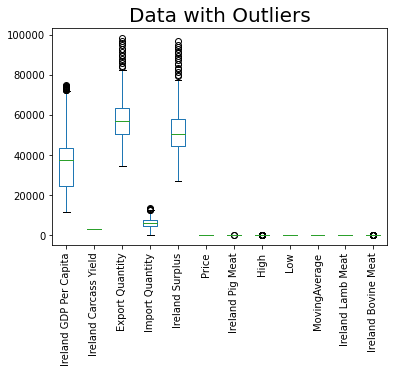

In [127]:
data.data.drop(columns=['Ireland GDP', 'Ireland Population']).plot(kind='box', rot=90)
plt.title('Data with Outliers', fontsize=20);

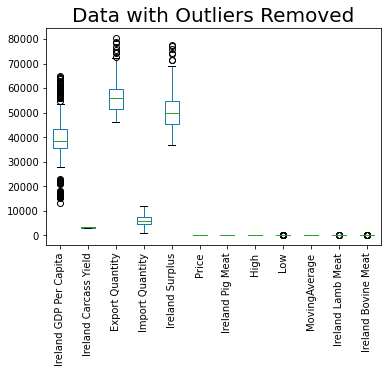

In [128]:
data.dataNoOutliers.drop(columns=['Ireland GDP', 'Ireland Population']).plot(kind='box', rot=90)
plt.title('Data with Outliers Removed', fontsize=20);

# Machine Learning Models

Now that the EDA and statistical analysis has been done now it is to see if the model can predict the bovine production.  New regression models never used before will be used. First will be to visually see PCA and KMeans for best inputs and then this will be put into the models and compared for supervised and semi supervised machine learning. 

## Import Regression Models

Regression models XGBRegressor, Support Vector Regressor, and Baysian Ridge will be used in conjunction with Polynomial Features.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor
from sklearn.svm import SVR

## SKLearn Libraries

SK Learn libraries will be imported to help get best results.  KNN imputer will be used to impute the dataset.  Standard, MinMax and Robust scaler to see which scaler is best.  Pipeline in conjunction with column transformer will be used to implement the other libraries mentioned before and preprocess the data. Gridsearch Cross Validation will use to pick the best hyperparameters for the model.  Finally metrics will be imported to validate results of the models. 

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import Counter

## Parameter Dictionaries

I found that using dictionaries was much easier to input and see settings to iterate over.  This was the best way I could think of to iterate in Grid Search CV all the different parameters along with models, estimators, and scalers. 

In [131]:
regressors = {'XGBRegressor': XGBRegressor,
              'PolynomialFeatures': PolynomialFeatures,
              'SVR': SVR, 'Bayesian': BayesianRidge}

parameters = {'SVR': {'gridParams':
                    {'svr__C': [1, 10, 100, 1000],
                    'svr__gamma': [0.1, 0.001, 0.0001]}},
              'Bayesian': {'gridParams': 
                        {'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                          'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                         'bayesianridge__normalize': [True, False],
                         'bayesianridge__n_iter': [300, 400, 500, 1000]}},
             'XGBRegressor': {'gridParams': 
                    {'xgbregressor__max_depth': [2, 4, 6],
                    'xgbregressor__n_estimators': [50, 100, 200, 400, 500, 1000],
                    'xgbregressor__gamma': [0.01, 0.1, 1.0],
                    'xgbregressor__learning_rate': [0.001, 0.01, 0.1]}}, 
             'PolynomialFeatures': {'gridParams': 
                     {'polynomialfeatures__degree': [2, 3],
                                    'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                                      'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                                     'bayesianridge__normalize': [True, False],
                                     'bayesianridge__n_iter': [300, 400, 500, 1000]}}}

addEstimators = {'PCA': PCA(n_components=0.95), 'KMeans': KMeans(n_clusters=5),'None': None}

scalers = {'Standard Scaler': StandardScaler(),
          'Min Max Scaler': MinMaxScaler(),
          'Robust Scaler': RobustScaler()}

## PCA Number of Components

Going through the dataset prior to going to train the models to see what is the best number of dimensions for the model.  Had to prepare the X, and y and the found that 0.95 in number of components captures the 95% of the data's variance.  This is the setting put into all models and there were improvement in XGBoost performance with PCA.

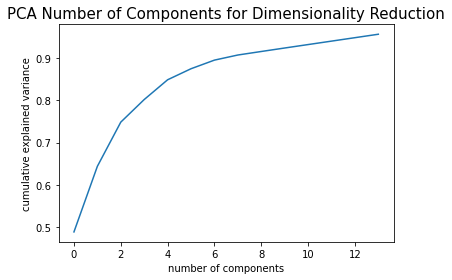

In [132]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

sca = RobustScaler()
imputer = KNNImputer(n_neighbors=3)
encoder = OneHotEncoder(handle_unknown='ignore').fit(X[cat_cols])

X_transformed = pd.DataFrame(data=imputer.fit_transform(X[num_cols]), columns=num_cols)
X_transformed = pd.DataFrame(data=sca.fit_transform(X_transformed[num_cols]), columns=num_cols)
X_encoded = pd.DataFrame(data=encoder.transform(X[cat_cols]).toarray(), columns=encoder.get_feature_names())

X_transformed = pd.concat([X_transformed, X_encoded], axis=1)

pca = PCA(n_components=0.95).fit(X_transformed)
pca_transformed = pca.fit_transform(X_transformed)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Number of Components for Dimensionality Reduction', fontsize=15)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## K-Means Number of Clusters Elbow

Now to find the number of clusters best fit for this dataset using the elbow method.

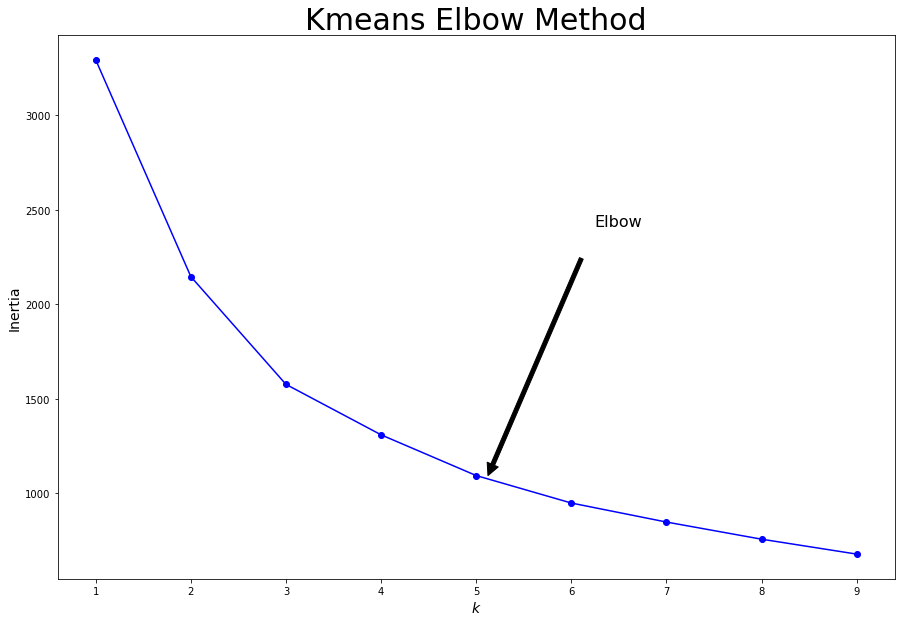

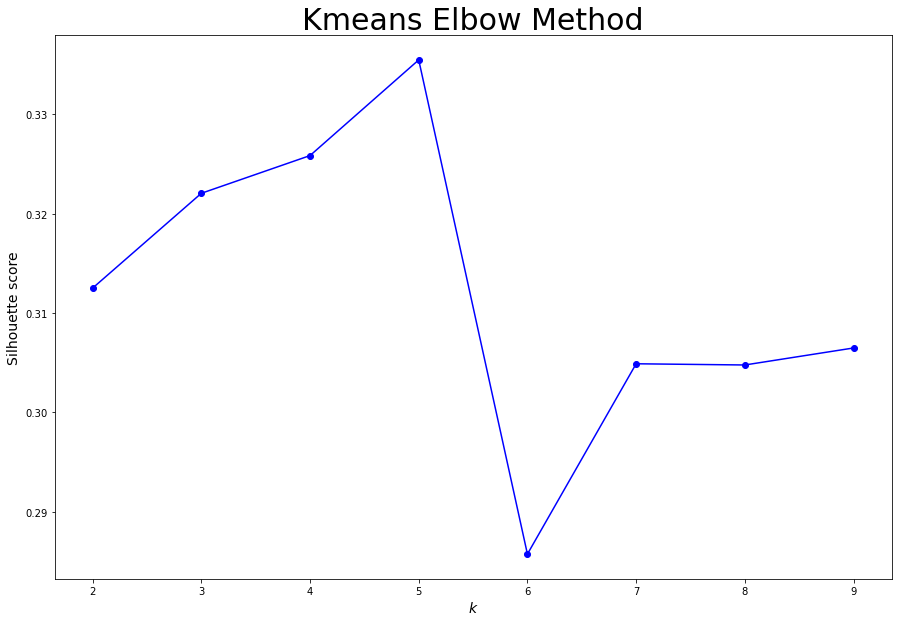

In [133]:
kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters)
    cutoff = 99
    kmeans.fit(pca_transformed[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    
kmeans_per_k = [KMeans(n_clusters=k).fit(pca_transformed)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(15, 10))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(5, inertias[5]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.title('Kmeans Elbow Method', fontsize=30)
plt.show()

from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(pca_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(15, 10))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.title('Kmeans Elbow Method', fontsize=30)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

## Regression Models

### Run Models with Outliers

In [135]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]
resultsOutliers = fn.Models().runModels(regressors, parameters, addEstimators, scalers, X, y, 'Outliers')

Model XGBRegressor
Result for this model is 0.640811 % 
Completed 2.78% 

Model PolynomialFeatures
Result for this model is 0.721018 % 
Completed 5.56% 

Model SVR
Result for this model is 0.195338 % 
Completed 8.33% 

Model Bayesian
Result for this model is 0.396607 % 
Completed 11.11% 

Model XGBRegressor
Result for this model is 0.706004 % 
Completed 13.89% 

Model PolynomialFeatures
Result for this model is 0.706388 % 
Completed 16.67% 

Model SVR
Result for this model is 0.578364 % 
Completed 19.44% 

Model Bayesian
Result for this model is 0.547620 % 
Completed 22.22% 

Model XGBRegressor
Result for this model is 0.722884 % 
Completed 25.0% 

Model PolynomialFeatures
Result for this model is 0.761317 % 
Completed 27.78% 

Model SVR
Result for this model is 0.304478 % 
Completed 30.56% 

Model Bayesian
Result for this model is 0.405315 % 
Completed 33.33% 

Model XGBRegressor
Result for this model is 0.405524 % 
Completed 36.11% 

Model PolynomialFeatures
Result for this model is 

### Run Models Without Outliers

In [ ]:
X, y = data.dataNoOutliers.iloc[:, :-1], data.dataNoOutliers.iloc[:, -1]
resultsNoOutliers = fn.Models().runModels(regressors, parameters, addEstimators, scalers, X, y, 'No Outliers')

Model XGBRegressor
Result for this model is 0.657746 % 
Completed 2.78% 

Model PolynomialFeatures
Result for this model is 0.741679 % 
Completed 5.56% 

Model SVR
Result for this model is 0.187154 % 
Completed 8.33% 

Model Bayesian
Result for this model is 0.413286 % 
Completed 11.11% 

Model XGBRegressor
Result for this model is 0.717768 % 
Completed 13.89% 

Model PolynomialFeatures
Result for this model is 0.699116 % 
Completed 16.67% 

Model SVR
Result for this model is 0.603075 % 
Completed 19.44% 

Model Bayesian
Result for this model is 0.575329 % 
Completed 22.22% 

Model XGBRegressor
Result for this model is 0.681591 % 
Completed 25.0% 

Model PolynomialFeatures
Result for this model is 0.793384 % 
Completed 27.78% 

Model SVR
Result for this model is 0.701742 % 
Completed 30.56% 

Model Bayesian
Result for this model is 0.473912 % 
Completed 33.33% 

Model XGBRegressor
Result for this model is 0.664181 % 
Completed 36.11% 

Model PolynomialFeatures
Result for this model is 

## All Model Results

In [ ]:
outResults = pd.DataFrame(resultsOutliers)
noOutResults = pd.DataFrame(resultsNoOutliers)
allResults = pd.concat([outResults, noOutResults], axis=0)
allResults.sort_values(by='R2 Score', ascending=False, inplace=True)
allResults.reset_index(inplace=True, drop=True)
allResults.head(25)

In [ ]:
allResults.to_csv('otherSpreadsheets/ModelResults22052022.csv', index=False)

In [ ]:
allResults =pd.read_csv('otherSpreadsheets/ModelResults19052022.csv')
allResults

In [ ]:
allResults[['Model Name', 'R2 Score']].groupby(by='Model Name').mean().sort_values('R2 Score', ascending=False).iplot(kind='bar');

In [ ]:
allResults[['Scaler', 'R2 Score']].groupby(by='Scaler').mean().sort_values('R2 Score', ascending=False).iplot(kind='bar');

In [ ]:
allResults[['Outliers', 'R2 Score']].groupby(by='Outliers').mean().sort_values('R2 Score', ascending=False).iplot(kind='bar');

In [ ]:
allResults[['Dimension Reducer', 'R2 Score']].groupby(by='Dimension Reducer').mean().sort_values('R2 Score', ascending=False).iplot(kind='bar');

In [ ]:
allResults.head(2).T

In [ ]:
allResults.loc[0, 'Best Parameters']

In [ ]:
allResults.loc[4,'Best Parameters']

In [ ]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create num columns for pipeline.
num_pipe = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())

pipe = make_pipeline(ColumnTransformer([('cat', 
            OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', num_pipe, num_cols)]), RandomForestRegressor(bootstrap=True, 
                                                                max_depth=50, n_estimators=20))

pipe.fit(X,y)

In [ ]:
pipe.score(X,y)

In [ ]:
randFeats = pipe.named_steps['randomforestregressor'].feature_importances_.astype('object')
colNames = np.concatenate((X.columns.drop('Month'), 
            pipe.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names()),
            axis=0)

rfFeats = pd.DataFrame(data=randFeats, columns=['Importance'], index=colNames)
rfFeats.sort_values(by= 'Importance', inplace=True, ascending=False)

rfFeats.plot(kind='bar')
plt.xlabel("Random Forest Feature Importance");

# Dashboard

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard, ExplainerHub
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

sca = RobustScaler()
imputer = KNNImputer(n_neighbors=3)
encoder = OneHotEncoder(handle_unknown='ignore').fit(X[cat_cols])

X_transformed = pd.DataFrame(data=imputer.fit_transform(X[num_cols]), columns=num_cols)
X_transformed = pd.DataFrame(data=sca.fit_transform(X_transformed[num_cols]), columns=num_cols)
X_encoded = pd.DataFrame(data=encoder.transform(X[cat_cols]).toarray(), columns=encoder.get_feature_names())

X_transformed = pd.concat([X_transformed, X_encoded], axis=1)

rf = RandomForestRegressor(bootstrap=True, max_depth=70, n_estimators=30)

rf.fit(X_transformed,y)

rf.score(X_transformed, y)

In [ ]:
xgb = XGBRegressor(gamma=0.1, learning_rate=0.1, max_depth=4, n_estimators=100)
xgb.fit(X_transformed, y)
xgb.score(X_transformed, y)

In [ ]:
allResults['Model Name'].unique()

In [ ]:
allResults[(allResults['Model Name'] != 'XGBRegressor') & (allResults['Model Name'] != 'RandomForestRegressor')]

In [ ]:
Counter({k: v for k, v in sorted(xgb.get_fscore().items(), key=lambda item: item[1], reverse = True)}).most_common

In [ ]:
xgb.feature_importances_

In [ ]:
data.data

In [ ]:
import streamlit as st

In [ ]:
header = st.beta_container()
dataset = st.beta_container()
features = st.beta_container()
model_training = st.beta_container()

st.markdown(
    """
    <style>
    .main {background-color: #F5F5F5;}
    </style>
    """, unsafe_allow_html=True)

@st.cache
def get_data(filename):
    taxi_data = data.data.copy()
    return taxi_data

with header:
    st.title('Welcome to my awesome data science project!')
    st.text('In this project I look into the transactions of taxis in NYC. ...')

with dataset:
    st.header('NYC taxi dataset')
    st.text('I foudn this dataset on blablabla.com, ...')

    taxi_data = get_data('data/taxi_data.csv')

    st.subheader('Pick-up location ID distribution on the NYC dataset')
    pulocation_dist = pd.DataFrame(taxi_data['Ireland GDP Per Capita'].value_counts()).head(50)
    st.bar_chart(pulocation_dist)


with features:
    st.header('The features I created')

    st.markdown('* **first feature:** I created this feature because of this... I calculated it using this logic..')
    st.markdown('* **second feature:** I created this feature because of this... I calculated it using this logic..')

with model_training:
    st.header('Time to train the model!')
    st.text('Here you get to choose the hyperparameters of the model and see how the performance changes!')

    sel_col, disp_col = st.beta_columns(2)

    max_depth = sel_col.slider('What should be the max_depth of the model?', min_value=10, max_value=100, value=20, step=10)

    n_estimators = sel_col.selectbox('How many trees should there be?', options=[100,200,300,'No limit'], index = 0)

    sel_col.text('Here is a list of features in my data:')
    sel_col.write(taxi_data.columns)

    input_feature = sel_col.text_input('Which feature should be used as the input feature?','PULocationID')


    if n_estimators == 'No limit':
        regr = RandomForestRegressor(max_depth=max_depth)
    else:
        regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)


    X = taxi_data[[input_feature]]
    y = taxi_data[['Ireland Bovine Meat']]

    regr.fit(X, y)
    prediction = regr.predict(y)

    disp_col.subheader('Mean absolute error of the model is:')
    disp_col.write(mean_absolute_error(y, prediction))

    disp_col.subheader('Mean squared error of the model is:')
    disp_col.write(mean_squared_error(y, prediction))

    disp_col.subheader('R squared score of the model is:')
    disp_col.write(r2_score(y, prediction))

In [ ]:
import os
db1 = ExplainerDashboard(RegressionExplainer(xgb, X_transformed, y), title='XGBoost Regression')
db2 = ExplainerDashboard(RegressionExplainer(rf, X_transformed, y), title='Random Forest Regression')
hub = ExplainerHub([db1, db2], secret_key=os.environ.get('dcb34dca-d334-4aa5-b9d6-9d36efe2fac3'))

hub.run(port=8050)

In [ ]:
ExplainerDashboard.terminate(8050)

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor


In [ ]:
allResults['Model Name'].unique()

In [ ]:
allResults['Best Parameters'][allResults['Model Name'] == 'Polynomial Features Bayesian'].head(1).reset_index(drop=True)

In [ ]:
import ast


In [ ]:
def bestParameters(modelName, columnNames):
    df = pd.DataFrame.from_dict(
        ast.literal_eval(allResults['Best Parameters'][allResults['Model Name'] == modelName].head(1).reset_index(drop=True)[0]),
        orient='index', columns=['Value'])
    params = {}

    for i in range(len(columnNames)):
        params[columnNames[i]] = df.iloc[i].values[0]

    return params

In [ ]:
bestParameters('XGBRegressor', ['gamma','learning_rate', 'max_depgh', 'n_estimators'])

In [ ]:
XGBRegressor(bestParameters('XGBRegressor', ['gamma','learning_rate', 'max_depgh', 'n_estimators']))

In [ ]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_dataPoly = poly_transformer.fit_transform(X_transformed)

bay = BayesianRidge(bestParameters('Polynomial Features Bayesian', 
                             ['alpha_init','lambda_init','normalize','n_iter']))



In [ ]:
bestParameters('Polynomial Features Bayesian', 
                             ['alpha_init','lambda_init','normalize','n_iter'])

In [ ]:
bay.fit(X_transformed, y)

In [ ]:
'svr__C': [1, 10, 100, 1000],
                    'svr__gamma': [0.1, 0.001, 0.0001]}},
              'Bayesian': {'gridParams': 
                        {'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                          'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                         'bayesianridge__normalize': [True, False],
                         'bayesianridge__n_iter': [300, 400, 500, 1000]}},
             'XGBRegressor': {'gridParams': 
                    {'xgbregressor__max_depth': [2, 4, 6],
                    'xgbregressor__n_estimators': [50, 100, 200, 400, 500, 1000],
                    'xgbregressor__gamma': [0.01, 0.1, 1.0],
                    'xgbregressor__learning_rate': [0.001, 0.01, 0.1]}}, 
             'PolynomialFeatures': {'gridParams': 
                     {'polynomialfeatures__degree': [2, 3],
                                    'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                                      'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                                     'bayesianridge__normalize': [True, False],
                                     'bayesianridge__n_iter': [300, 400, 500, 1000]}}}

In [ ]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

app = Dash(__name__)

models = {'Suppor Vector Machine': SVR(),
        'Ridge Regression': Ridge(alpha=10.0, normalize=False),
          'Random Forest': RandomForestRegressor(bootstrap=True, max_depth=70, n_estimators=30),
          'K-NN': KNeighborsRegressor(n_neighbors=10, p=2),
         'XGB Boost': XGBRegressor(gamma=0.1, learning_rate=0.1, max_depth=4, n_estimators=100)}

app.layout = html.Div([
    html.H4("Predicting Ireland's Monthly Beef Production"),
    html.P("Select model:"),
    dcc.Dropdown(
        id='dropdown',
        options=["Suppor Vector Machine", "Ridge Regression", "Random Forest", "K-NN", "XGB Boost"],
        value='Random Forest',
        clearable=False),
    dcc.Graph(id="graph"),])

@app.callback(
    Output("graph", "figure"), 
    Input('dropdown', "value"))
def train_and_display(name):
    model = models[name]
    model.fit(X_transformed, y)

    showAmount = len(X) - 120
    y_pred = model.predict(X_transformed[showAmount:])

    fig = go.Figure([
        go.Scatter(x=X.index[showAmount:], y=y[showAmount:], 
                   name='Actual', mode='markers'),
        go.Scatter(x=X.index[showAmount:], y=y_pred, 
                   name='Prediction')])
    return fig

app.run_server(debug=True, use_reloader=False)